<h1>Teoretiska frågor</h1>

<h2>Relationsdatabas</h2>

En relationsdatabas är en samling av tabeller som är relaterade till varandra med hjälp av "nyckelegenskaper" som särskiljer raderna i varje tabell. Tanken med att ha relationsdatabaser är att undvika överflödiga rader som bara har en viss egenskap gemensamt.

<h2>CRUD</h2>

Crud står för Create, Read, Update, och Delete, dvs skapa, läs, uppdatera och ta bort, vilka är de fundamentala funktionerna som kommer till användning just för att skapa och hantera en databas. Ett CRUD-flöde består därför av en blandning av desssa funktioner som kommer i en sekvens och möjliggör hanteringen.

<h2>Left Join och Inner Join</h2>

Man får se två databas tabeller som mängder, där join innebär att dessa kombineras för att få en ny tabell. Left join innebär att alla rader från den första databasen tas med och motsvarande rader i den andra tabellen tillför information på samma rader som den första. Där den andra tabellen inte har någon ytterligare information kommer det att ersättas med NULL. Inner join, å andra sidan fyller den nya tabellen med de rader där både den första och den andra tabellen har information att tillföra. För de rader där den ena eller den andra inte innehåller någon information kommer ingen ny rad att skapas i den nya tabellen heller.

In [152]:
!pip install matplotlib_venn

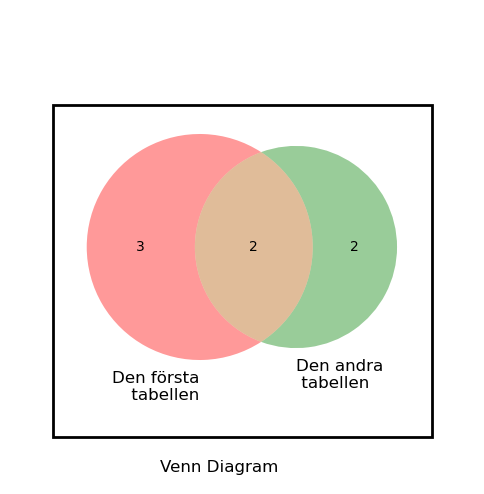

In [153]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Example data
set1 = {'a', 'b', 'c', 'd', 'e'}
set2 = {'d', 'e', 'f', 'g'}

# Set up Venn labels and colors
venn_labels = {'100': set1 - set2, '050': set2 - set1, '140': set1.intersection(set2)}
venn_colors = {'100': 'red', '050': 'green', '140': 'blue'}

# Set figure size
plt.figure(figsize=(6, 6))

# Create a Venn diagram
venn2([set1, set2], set_labels=('Den första\n tabellen', 'Den andra\n tabellen'))

# Display the rectangle
plt.gca().add_patch(plt.Rectangle((-0.8, -0.8), 1.6, 1.4, fill=None, edgecolor='black', linewidth=2))

# Fine-tune the position of the labels
plt.text(-0.35, -0.9, 'Venn Diagram', ha='left', va='top', fontsize=12)
plt.text(0.35, -0.9, '', ha='right', va='top', fontsize=12)

# Fine-tune the position of the figure
plt.subplots_adjust(top=0.9)  # Adjust the 'top' parameter as needed

# Set equal aspect ratio
plt.axis('equal')

# Set plot limits
plt.xlim(-1, 1)
plt.ylim(-1, 1)

# Display the plot
plt.show()

<h2>Indexering</h2>

Indexering är att skapa en metod att söka och hitta en viss rad i en tabell utan att nödvändigtvis behöva iterera igenom varenda rad i den tabellen.

<h2>Vy</h2>
    
En vy är samma sak som en tabell och kan användas och hanteras på samma sätt. Det finns dock en väsentlig skillnaden; att en vy skapas i ramminnet och är tillgängligt att använda så länge databasen är aktiv och servern/ datorn är påslagen.

<h2>Lagrad procedur</h2>

Lagrad procedur, som namnet föreslår, är en samling av SQL-kommandon som redan har kompilerats och är redo för körning. Detta för att spara tid och minne, undvika redundans i koden och att ge möjligheten att tillhandahålla information till "extern" användare utan att denne ska ha direkt tillgång till databasen och källkoden.

<h1>Praktiska frågor</h1>

<h2>Beskrivning av databasen</h2>

<h2>Installation of Packages</h2>

In [40]:
!pip install sqlalchemy
!pip install pyodbc

In [41]:
!pip install --upgrade pyodbc

In [42]:
from sqlalchemy import create_engine, MetaData, Table, inspect
import pandas as pd

pd.set_option('display.max_columns', None) # to show the whole width of tables
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

<h2>Database Connection</h2>

In [43]:
def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # For Windows authentication
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+server"
    else:
        # For SQL Server authentication
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+for+SQL+Server"
    print(eng)
    return create_engine(eng)

In [44]:
# For Windows authentication
# Replace the server argument with the Server Name found when logging into SQL Management Studio
# OR
# For SQL Server authentication
# Replace the server, user and password argument with the Server Name, username and password
engine = new_engine('mssql', 'DESKTOP-PJ0B80O', 'AdventureWorks2022', integrated_security=True)

mssql://DESKTOP-PJ0B80O/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+server


In [45]:
print(type(engine))

<class 'sqlalchemy.engine.base.Engine'>


In [46]:
connection = engine.connect()
print(type(connection))

<class 'sqlalchemy.engine.base.Connection'>


<h2>Preparation of Schemas and Tables</h2>

In [47]:
inspector = inspect(engine)
schemas = inspector.get_schema_names()
print(schemas)

['db_accessadmin', 'db_backupoperator', 'db_datareader', 'db_datawriter', 'db_ddladmin', 'db_denydatareader', 'db_denydatawriter', 'db_owner', 'db_securityadmin', 'dbo', 'guest', 'HumanResources', 'INFORMATION_SCHEMA', 'Person', 'Production', 'Purchasing', 'Sales', 'sys']


<h2>Queries</h2>

Vi försöker först med att ta en snabb titt på alla tabeller i databasen.

In [265]:
# Find the name of all the tables in the database within each schema
# Create a dictionary to store queries and results
all_queries_dict = {}
for sch in schemas:
    for table in inspector.get_table_names(schema=sch):
        if sch != 'dbo':
            col_names = ', '.join(col['name'] for col in inspector.get_columns(table_name=table, schema=sch))
            full_table_name = f"{sch}_{table}"
            query = f"SELECT {col_names} FROM {sch}.{table}"
            all_queries_dict[full_table_name] = query

# Put the queries in action and print the results
for full_table_name, query in all_queries_dict.items():
    print("QUERY\n------\n", query, "\n", "----------------------------------------------")
    try:
        df_table = pd.read_sql(sql=query, con=connection)
        all_queries_dict[full_table_name] = df_table  # Store the DataFrame in the dictionary
        (schema_name, table_name) = full_table_name.split('_')
        print(f"Schema: {schema_name}\nTable: {table_name}\n")
        print(df_table.head(5))
        print(df_table.describe())
    except Exception as e:
        print(f"Error executing query: {e}")
    print("\n"*3)

QUERY
------
 SELECT DepartmentID, Name, GroupName, ModifiedDate FROM HumanResources.Department 
 ----------------------------------------------
Schema: HumanResources
Table: Department

   DepartmentID         Name                 GroupName ModifiedDate
0             1  Engineering  Research and Development   2008-04-30
1             2  Tool Design  Research and Development   2008-04-30
2             3        Sales       Sales and Marketing   2008-04-30
3             4    Marketing       Sales and Marketing   2008-04-30
4             5   Purchasing      Inventory Management   2008-04-30
       DepartmentID         ModifiedDate
count     16.000000                   16
mean       8.500000  2008-04-30 00:00:00
min        1.000000  2008-04-30 00:00:00
25%        4.750000  2008-04-30 00:00:00
50%        8.500000  2008-04-30 00:00:00
75%       12.250000  2008-04-30 00:00:00
max       16.000000  2008-04-30 00:00:00
std        4.760952                  NaN




QUERY
------
 SELECT BusinessEnt

Schema: Person
Table: BusinessEntity

   BusinessEntityID                               rowguid  \
0                 1  0C7D8F81-D7B1-4CF0-9C0A-4CD8B6B50087   
1                 2  6648747F-7843-4002-B317-65389684C398   
2                 3  568204DA-93D7-42F4-8A7A-4446A144277D   
3                 4  0EFF57B9-4F4F-41A6-8867-658C199A5FC0   
4                 5  B82F88D1-FF79-4FD9-8C54-9D24C140F647   

             ModifiedDate  
0 2017-12-13 13:20:24.150  
1 2017-12-13 13:20:24.430  
2 2017-12-13 13:20:24.540  
3 2017-12-13 13:20:24.570  
4 2017-12-13 13:20:24.633  
       BusinessEntityID                   ModifiedDate
count      20777.000000                          20777
mean       10389.000000  2017-12-13 13:32:46.451431936
min            1.000000     2017-12-13 13:20:24.150000
25%         5195.000000  2017-12-13 13:25:19.816999936
50%        10389.000000  2017-12-13 13:32:24.409999872
75%        15583.000000  2017-12-13 13:39:46.423000064
max        20777.000000     2017-12-13 13:

Schema: Person
Table: Person

   BusinessEntityID PersonType  NameStyle Title FirstName MiddleName  \
0                 1         EM      False  None       Ken          J   
1                 2         EM      False  None     Terri        Lee   
2                 3         EM      False  None   Roberto       None   
3                 4         EM      False  None       Rob       None   
4                 5         EM      False   Ms.      Gail          A   

     LastName Suffix  EmailPromotion AdditionalContactInfo  \
0     Sánchez   None               0                  None   
1       Duffy   None               1                  None   
2  Tamburello   None               0                  None   
3     Walters   None               0                  None   
4    Erickson   None               0                  None   

                                        Demographics  \
0  <IndividualSurvey xmlns="http://schemas.micros...   
1  <IndividualSurvey xmlns="http://schemas.micros...

Schema: Production
Table: Product

   ProductID                   Name ProductNumber  MakeFlag  \
0          1        Adjustable Race       AR-5381     False   
1          2           Bearing Ball       BA-8327     False   
2          3        BB Ball Bearing       BE-2349      True   
3          4  Headset Ball Bearings       BE-2908     False   
4        316                  Blade       BL-2036      True   

   FinishedGoodsFlag Color  SafetyStockLevel  ReorderPoint  StandardCost  \
0              False  None              1000           750           0.0   
1              False  None              1000           750           0.0   
2              False  None               800           600           0.0   
3              False  None               800           600           0.0   
4              False  None               800           600           0.0   

   ListPrice  ... ProductLine Class Style  ProductSubcategoryID  \
0        0.0  ...        None  None  None                   Na

       ProductDescriptionID                   ModifiedDate
count            762.000000                            762
mean            1542.582677  2013-06-16 00:47:51.633330944
min                3.000000            2013-04-30 00:00:00
25%             1429.250000            2013-04-30 00:00:00
50%             1620.500000            2013-04-30 00:00:00
75%             1814.750000            2013-04-30 00:00:00
max             2010.000000     2014-02-08 10:32:17.973000
std              388.528836                            NaN




QUERY
------
 SELECT ProductID, DocumentNode, ModifiedDate FROM Production.ProductDocument 
 ----------------------------------------------
Error executing query: (pyodbc.ProgrammingError) ('ODBC SQL type -151 is not yet supported.  column-index=1  type=-151', 'HY106')
(Background on this error at: https://sqlalche.me/e/14/f405)




QUERY
------
 SELECT ProductID, LocationID, Shelf, Bin, Quantity, rowguid, ModifiedDate FROM Production.ProductInventory 
 -------

       ProductReviewID   ProductID           ReviewDate    Rating  \
count         4.000000    4.000000                    4  4.000000   
mean          2.500000  845.250000  2013-10-31 00:00:00  4.000000   
min           1.000000  709.000000  2013-09-18 00:00:00  2.000000   
25%           1.750000  775.750000  2013-10-30 00:00:00  3.500000   
50%           2.500000  867.500000  2013-11-14 00:00:00  4.500000   
75%           3.250000  937.000000  2013-11-15 00:00:00  5.000000   
max           4.000000  937.000000  2013-11-15 00:00:00  5.000000   
std           1.290994  112.001116                  NaN  1.414214   

              ModifiedDate  
count                    4  
mean   2013-10-31 00:00:00  
min    2013-09-18 00:00:00  
25%    2013-10-30 00:00:00  
50%    2013-11-14 00:00:00  
75%    2013-11-15 00:00:00  
max    2013-11-15 00:00:00  
std                    NaN  




QUERY
------
 SELECT ProductSubcategoryID, ProductCategoryID, Name, rowguid, ModifiedDate FROM Production.Product

Schema: Production
Table: WorkOrder

   WorkOrderID  ProductID  OrderQty  StockedQty  ScrappedQty  StartDate  \
0            1        722         8           8            0 2011-06-03   
1            2        725        15          15            0 2011-06-03   
2            3        726         9           9            0 2011-06-03   
3            4        729        16          16            0 2011-06-03   
4            5        730        14          14            0 2011-06-03   

     EndDate    DueDate  ScrapReasonID ModifiedDate  
0 2011-06-13 2011-06-14            NaN   2011-06-13  
1 2011-06-13 2011-06-14            NaN   2011-06-13  
2 2011-06-13 2011-06-14            NaN   2011-06-13  
3 2011-06-13 2011-06-14            NaN   2011-06-13  
4 2011-06-13 2011-06-14            NaN   2011-06-13  
        WorkOrderID     ProductID      OrderQty    StockedQty   ScrappedQty  \
count  72591.000000  72591.000000  72591.000000  72591.000000  72591.000000   
mean   36296.000000    704.327

Schema: Purchasing
Table: PurchaseOrderDetail

   PurchaseOrderID  PurchaseOrderDetailID    DueDate  OrderQty  ProductID  \
0                1                      1 2011-04-30         4          1   
1                2                      2 2011-04-30         3        359   
2                2                      3 2011-04-30         3        360   
3                3                      4 2011-04-30       550        530   
4                4                      5 2011-04-30         3          4   

   UnitPrice  LineTotal  ReceivedQty  RejectedQty  StockedQty ModifiedDate  
0    50.2600   201.0400          3.0          0.0         3.0   2011-04-23  
1    45.1200   135.3600          3.0          0.0         3.0   2011-04-23  
2    45.5805   136.7415          3.0          0.0         3.0   2011-04-23  
3    16.0860  8847.3000        550.0          0.0       550.0   2011-04-23  
4    57.0255   171.0765          2.0          1.0         1.0   2011-04-23  
       PurchaseOrderID  Purc

Schema: Sales
Table: CreditCard

   CreditCardID       CardType      CardNumber  ExpMonth  ExpYear ModifiedDate
0             1   SuperiorCard  33332664695310        11     2006   2013-07-29
1             2    Distinguish  55552127249722         8     2005   2013-12-05
2             3  ColonialVoice  77778344838353         7     2005   2014-01-14
3             4  ColonialVoice  77774915718248         7     2006   2013-05-20
4             5          Vista  11114404600042         4     2005   2013-02-01
       CreditCardID      ExpMonth       ExpYear                   ModifiedDate
count  19118.000000  19118.000000  19118.000000                          19118
mean    9567.669526      6.527304   2006.500105  2013-05-22 13:20:04.017156352
min        1.000000      1.000000   2005.000000            2006-06-23 00:00:00
25%     4780.250000      4.000000   2006.000000            2012-12-19 00:00:00
50%     9559.500000      7.000000   2007.000000            2013-09-14 00:00:00
75%    14338.750000

Schema: Sales
Table: SalesOrderHeader

   SalesOrderID  RevisionNumber  OrderDate    DueDate   ShipDate  Status  \
0         43659               8 2011-05-31 2011-06-12 2011-06-07       5   
1         43660               8 2011-05-31 2011-06-12 2011-06-07       5   
2         43661               8 2011-05-31 2011-06-12 2011-06-07       5   
3         43662               8 2011-05-31 2011-06-12 2011-06-07       5   
4         43663               8 2011-05-31 2011-06-12 2011-06-07       5   

   OnlineOrderFlag SalesOrderNumber PurchaseOrderNumber   AccountNumber  ...  \
0            False          SO43659         PO522145787  10-4020-000676  ...   
1            False          SO43660       PO18850127500  10-4020-000117  ...   
2            False          SO43661       PO18473189620  10-4020-000442  ...   
3            False          SO43662       PO18444174044  10-4020-000227  ...   
4            False          SO43663       PO18009186470  10-4020-000510  ...   

   CreditCardID  Credit

Error executing query: (pyodbc.ProgrammingError) ('42000', "[42000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Incorrect syntax near the keyword 'Group'. (156) (SQLExecDirectW)")
[SQL: SELECT TerritoryID, Name, CountryRegionCode, Group, SalesYTD, SalesLastYear, CostYTD, CostLastYear, rowguid, ModifiedDate FROM Sales.SalesTerritory]
(Background on this error at: https://sqlalche.me/e/14/f405)




QUERY
------
 SELECT BusinessEntityID, TerritoryID, StartDate, EndDate, rowguid, ModifiedDate FROM Sales.SalesTerritoryHistory 
 ----------------------------------------------
Schema: Sales
Table: SalesTerritoryHistory

   BusinessEntityID  TerritoryID  StartDate    EndDate  \
0               275            2 2011-05-31 2012-11-29   
1               275            3 2012-11-30        NaT   
2               276            4 2011-05-31        NaT   
3               277            3 2011-05-31 2012-11-29   
4               277            2 2012-11-30        NaT   

                     

       BusinessEntityID  SalesPersonID                   ModifiedDate
count        701.000000     701.000000                            701
mean        1035.878745     281.044223  2014-09-12 11:15:07.497000192
min          292.000000     275.000000     2014-09-12 11:15:07.497000
25%          642.000000     277.000000  2014-09-12 11:15:07.496999936
50%          992.000000     281.000000  2014-09-12 11:15:07.496999936
75%         1342.000000     283.000000  2014-09-12 11:15:07.496999936
max         2051.000000     290.000000     2014-09-12 11:15:07.497000
std          477.742331       4.577215                            NaN






Vi noterar att schemas Person och Sales innehåller mycket information som är relaterade till företagets kunder. Detta väljer vi som ämne för vår analys och framställer samma tabeller ännu en gång för att lättare undersöka sambanden mellan tabeller som innehåller all information om kunderna.

QUERY
------
 SELECT AddressID, AddressLine1, AddressLine2, City, StateProvinceID, PostalCode, SpatialLocation, rowguid, ModifiedDate FROM Person.Address 
 ----------------------------------------------
Error executing query: (pyodbc.ProgrammingError) ('ODBC SQL type -151 is not yet supported.  column-index=6  type=-151', 'HY106')
(Background on this error at: https://sqlalche.me/e/14/f405)




QUERY
------
 SELECT AddressTypeID, Name, rowguid, ModifiedDate FROM Person.AddressType 
 ----------------------------------------------
Schema: Person
Table: AddressType

   AddressTypeID         Name                               rowguid  \
0              1      Billing  B84F78B1-4EFE-4A0E-8CB7-70E9F112F886   
1              2         Home  41BC2FF6-F0FC-475F-8EB9-CEC0805AA0F2   
2              3  Main Office  8EEEC28C-07A2-4FB9-AD0A-42D4A0BBC575   
3              4      Primary  24CB3088-4345-47C4-86C5-17B535133D1E   
4              5     Shipping  B29DA3F8-19A3-47DA-9DAA-15C84F4A83A5   

  M

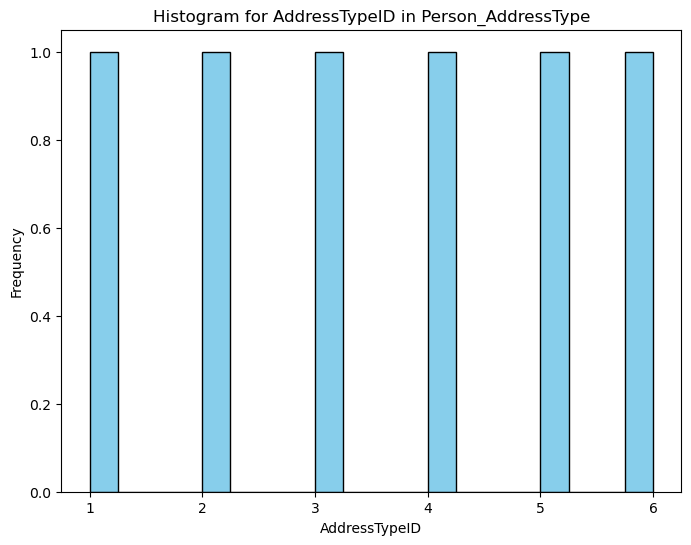





QUERY
------
 SELECT BusinessEntityID, rowguid, ModifiedDate FROM Person.BusinessEntity 
 ----------------------------------------------
Schema: Person
Table: BusinessEntity

   BusinessEntityID                               rowguid  \
0                 1  0C7D8F81-D7B1-4CF0-9C0A-4CD8B6B50087   
1                 2  6648747F-7843-4002-B317-65389684C398   
2                 3  568204DA-93D7-42F4-8A7A-4446A144277D   
3                 4  0EFF57B9-4F4F-41A6-8867-658C199A5FC0   
4                 5  B82F88D1-FF79-4FD9-8C54-9D24C140F647   

             ModifiedDate  
0 2017-12-13 13:20:24.150  
1 2017-12-13 13:20:24.430  
2 2017-12-13 13:20:24.540  
3 2017-12-13 13:20:24.570  
4 2017-12-13 13:20:24.633  

Statistical Information:
       BusinessEntityID                   ModifiedDate
count      20777.000000                          20777
mean       10389.000000  2017-12-13 13:32:46.451431936
min            1.000000     2017-12-13 13:20:24.150000
25%         5195.000000  2017-12-13 13:2

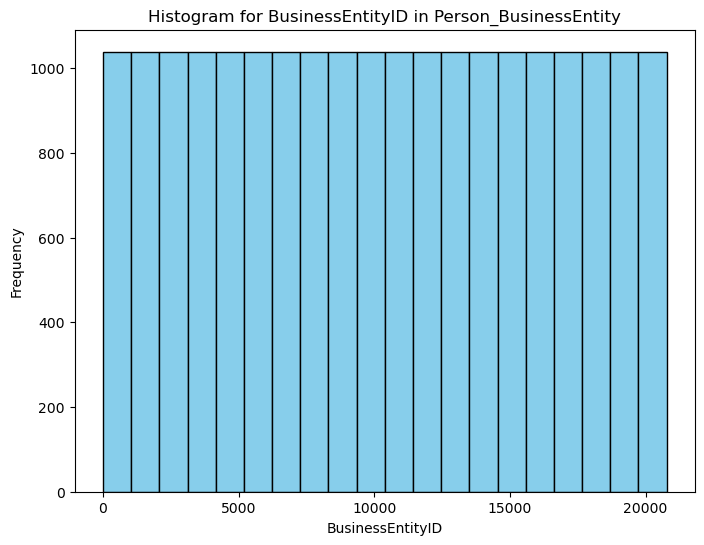





QUERY
------
 SELECT BusinessEntityID, AddressID, AddressTypeID, rowguid, ModifiedDate FROM Person.BusinessEntityAddress 
 ----------------------------------------------
Schema: Person
Table: BusinessEntityAddress

   BusinessEntityID  AddressID  AddressTypeID  \
0                 1        249              2   
1                 2        293              2   
2                 3        224              2   
3                 4      11387              2   
4                 5        190              2   

                                rowguid            ModifiedDate  
0  3A5D0A00-6739-4DFE-A8F7-844CD9DEE3DF 2014-09-12 11:15:06.967  
1  84AE7057-EDF4-4C51-8B8D-3AEAEFBFB4A1 2014-09-12 11:15:06.967  
2  3C915B31-7C05-4A05-9859-0DF663677240 2014-09-12 11:15:06.967  
3  3DC70CC4-3AE8-424F-8B1F-481C5478E941 2014-09-12 11:15:06.967  
4  C0ED2F68-937B-4594-9459-581AC53C98E3 2014-09-12 11:15:06.967  

Statistical Information:
       BusinessEntityID     AddressID  AddressTypeID  \
count   

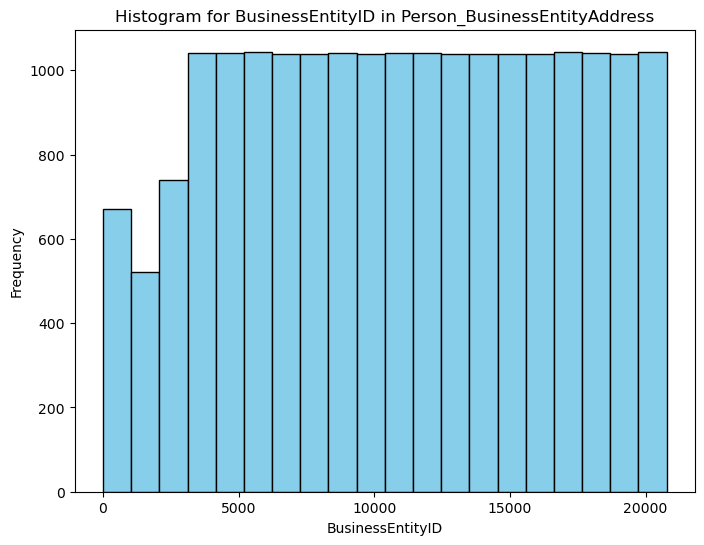

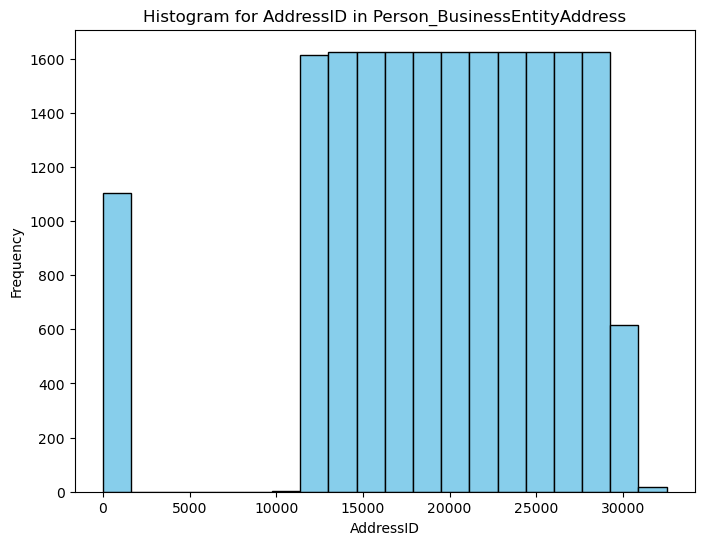

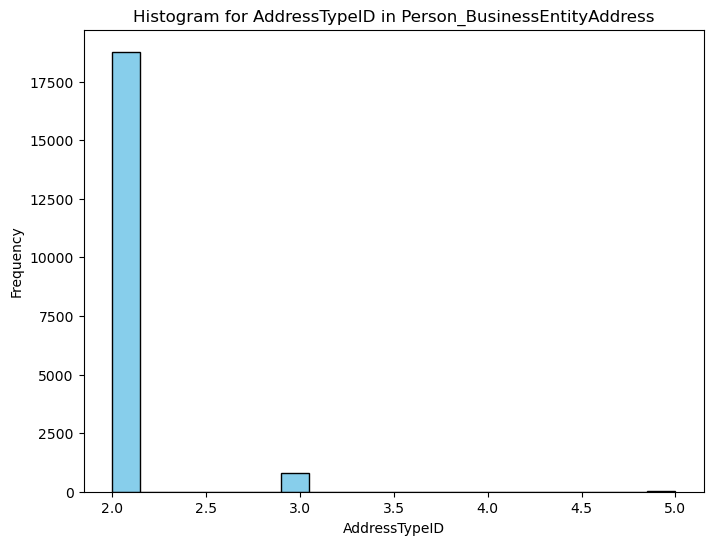





QUERY
------
 SELECT BusinessEntityID, PersonID, ContactTypeID, rowguid, ModifiedDate FROM Person.BusinessEntityContact 
 ----------------------------------------------
Schema: Person
Table: BusinessEntityContact

   BusinessEntityID  PersonID  ContactTypeID  \
0               292       291             11   
1               294       293             11   
2               296       295             11   
3               298       297             11   
4               300       299             11   

                                rowguid            ModifiedDate  
0  7D4D2DBC-4A44-48F5-911D-A63ABAFD5120 2017-12-13 13:21:02.243  
1  3EA25B65-9579-4260-977D-D6F00D7D20EE 2017-12-13 13:21:02.320  
2  DADAC1FF-3351-4827-9AE0-95004885C193 2017-12-13 13:21:02.383  
3  B924F26F-6446-45D1-A92B-6F418374F075 2017-12-13 13:21:02.447  
4  5BA4E7BE-8D29-46A2-B68D-67B1615B124A 2017-12-13 13:21:02.510  

Statistical Information:
       BusinessEntityID     PersonID  ContactTypeID  \
count        909

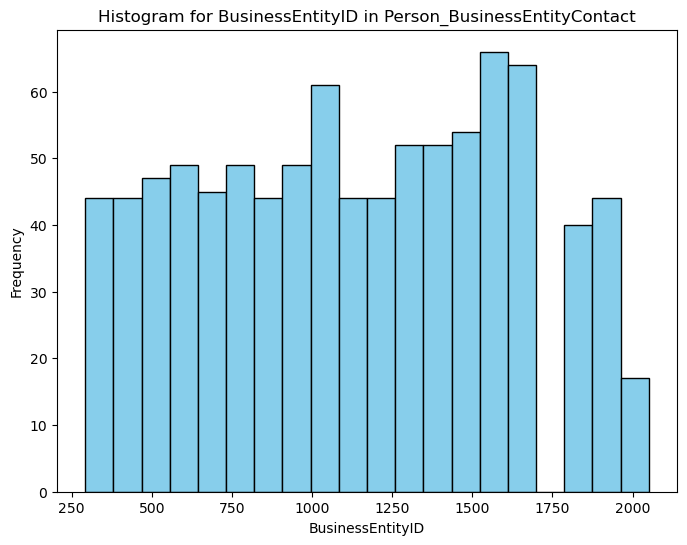

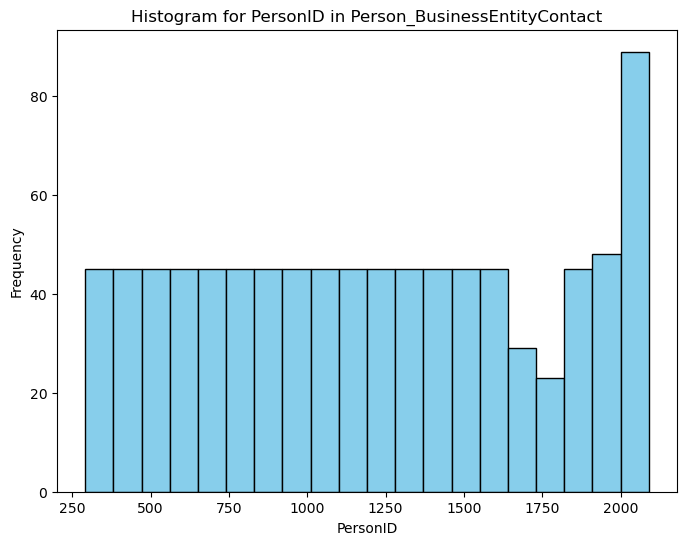

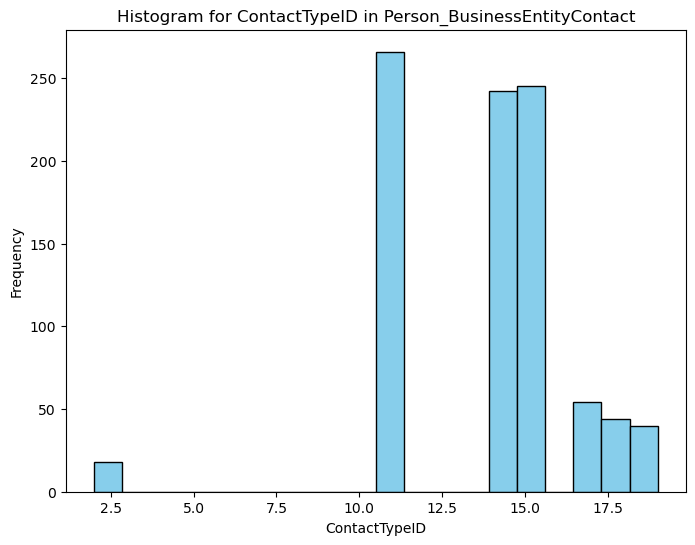





QUERY
------
 SELECT ContactTypeID, Name, ModifiedDate FROM Person.ContactType 
 ----------------------------------------------
Schema: Person
Table: ContactType

   ContactTypeID                            Name ModifiedDate
0              1              Accounting Manager   2008-04-30
1              2           Assistant Sales Agent   2008-04-30
2              3  Assistant Sales Representative   2008-04-30
3              4     Coordinator Foreign Markets   2008-04-30
4              5            Export Administrator   2008-04-30

Statistical Information:
       ContactTypeID         ModifiedDate
count       20.00000                   20
mean        10.50000  2008-04-30 00:00:00
min          1.00000  2008-04-30 00:00:00
25%          5.75000  2008-04-30 00:00:00
50%         10.50000  2008-04-30 00:00:00
75%         15.25000  2008-04-30 00:00:00
max         20.00000  2008-04-30 00:00:00
std          5.91608                  NaN


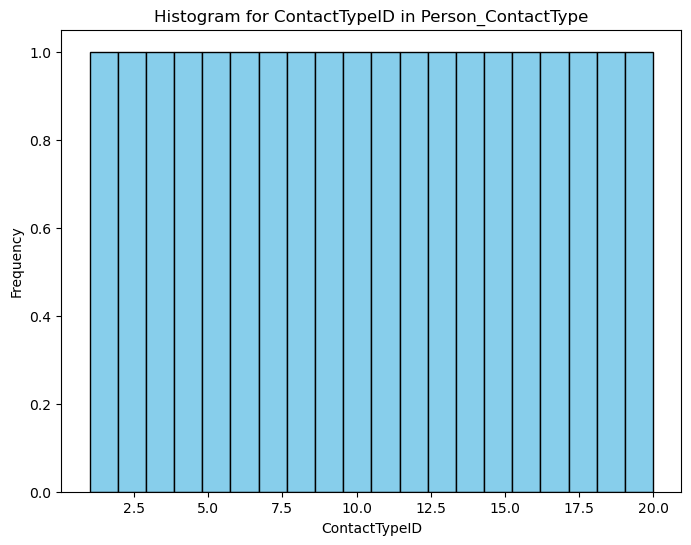





QUERY
------
 SELECT CountryRegionCode, Name, ModifiedDate FROM Person.CountryRegion 
 ----------------------------------------------
Schema: Person
Table: CountryRegion

  CountryRegionCode                  Name ModifiedDate
0                AD               Andorra   2008-04-30
1                AE  United Arab Emirates   2008-04-30
2                AF           Afghanistan   2008-04-30
3                AG   Antigua and Barbuda   2008-04-30
4                AI              Anguilla   2008-04-30

Statistical Information:
              ModifiedDate
count                  238
mean   2008-04-30 00:00:00
min    2008-04-30 00:00:00
25%    2008-04-30 00:00:00
50%    2008-04-30 00:00:00
75%    2008-04-30 00:00:00
max    2008-04-30 00:00:00




QUERY
------
 SELECT BusinessEntityID, EmailAddressID, EmailAddress, rowguid, ModifiedDate FROM Person.EmailAddress 
 ----------------------------------------------
Schema: Person
Table: EmailAddress

   BusinessEntityID  EmailAddressID             

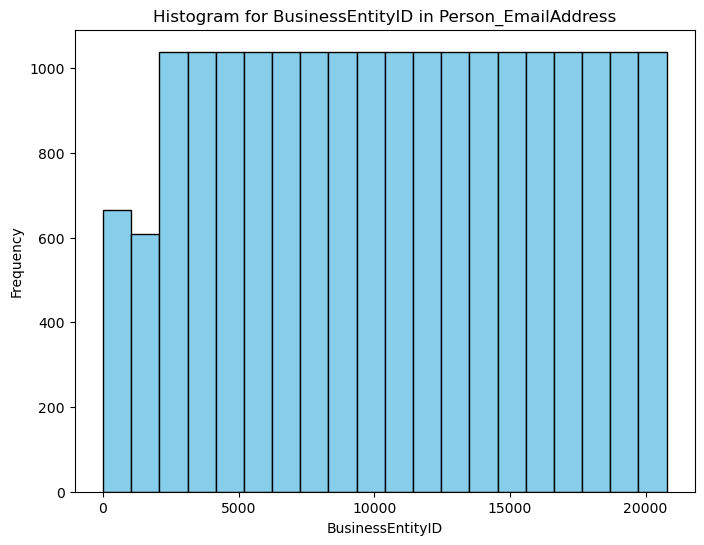

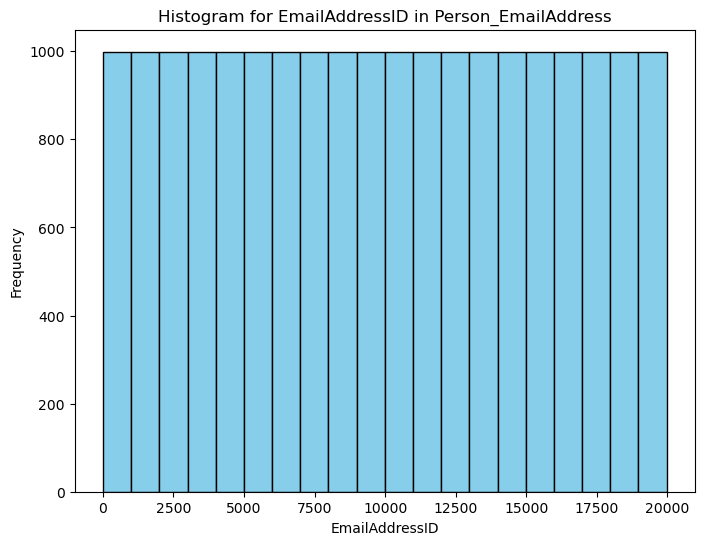





QUERY
------
 SELECT BusinessEntityID, PasswordHash, PasswordSalt, rowguid, ModifiedDate FROM Person.Password 
 ----------------------------------------------
Schema: Person
Table: Password

   BusinessEntityID                                  PasswordHash  \
0                 1  pbFwXWE99vobT6g+vPWFy93NtUU/orrIWafF01hccfM=   
1                 2  bawRVNrZQYQ05qF05Gz6VLilnviZmrqBReTTAGAudm0=   
2                 3  8BUXrZfDqO1IyHCWOYzYmqN1IhTUn3CJMpdx/UCQ3iY=   
3                 4  SjLXpiarHSlz+6AG+H+4QpB/IPRzras/+9q/5Wr7tf8=   
4                 5  8FYdAiY6gWuBsgjCFdg0UibtsqOcWHf9TyaHIP7+paA=   

  PasswordSalt                               rowguid ModifiedDate  
0     bE3XiWw=  329EACBE-C883-4F48-B8B6-17AA4627EFFF   2009-01-07  
1     EjJaC3U=  A4C82398-7466-4FE6-B9EE-CEC34D116F68   2008-01-24  
2     wbPZqMw=  AC3F4536-BB2E-41C5-B70D-454BE460C1BD   2007-11-04  
3     PwSunQU=  B3FA4C24-2E96-477C-A923-0CB0F6FA5C80   2007-11-28  
4     qYhZRiM=  C4D13BCF-0209-44C7-AC67-6F817FDD7F

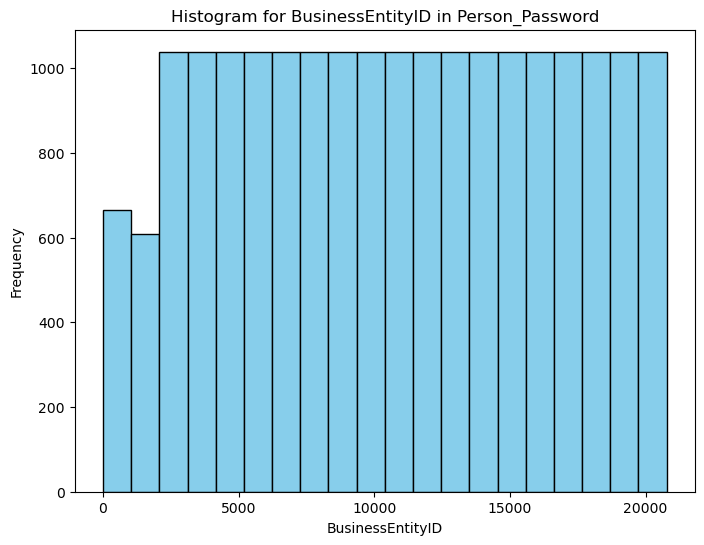





QUERY
------
 SELECT BusinessEntityID, PersonType, NameStyle, Title, FirstName, MiddleName, LastName, Suffix, EmailPromotion, AdditionalContactInfo, Demographics, rowguid, ModifiedDate FROM Person.Person 
 ----------------------------------------------
Schema: Person
Table: Person

   BusinessEntityID PersonType  NameStyle Title FirstName MiddleName  \
0                 1         EM      False  None       Ken          J   
1                 2         EM      False  None     Terri        Lee   
2                 3         EM      False  None   Roberto       None   
3                 4         EM      False  None       Rob       None   
4                 5         EM      False   Ms.      Gail          A   

     LastName Suffix  EmailPromotion AdditionalContactInfo  \
0     Sánchez   None               0                  None   
1       Duffy   None               1                  None   
2  Tamburello   None               0                  None   
3     Walters   None            

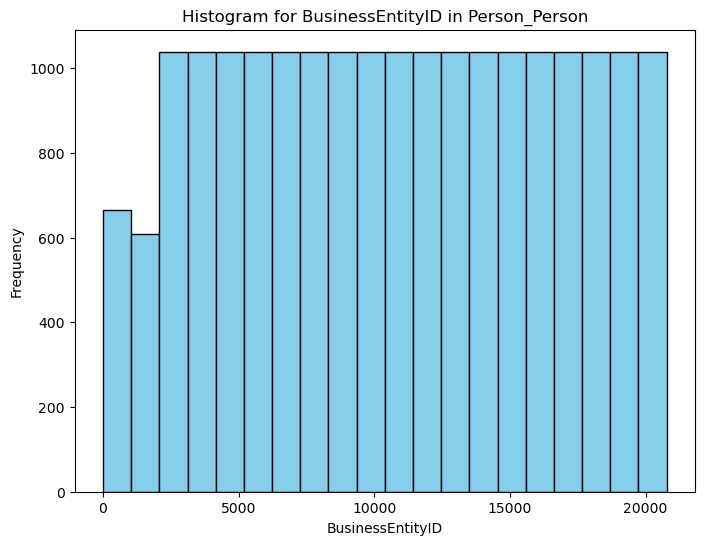

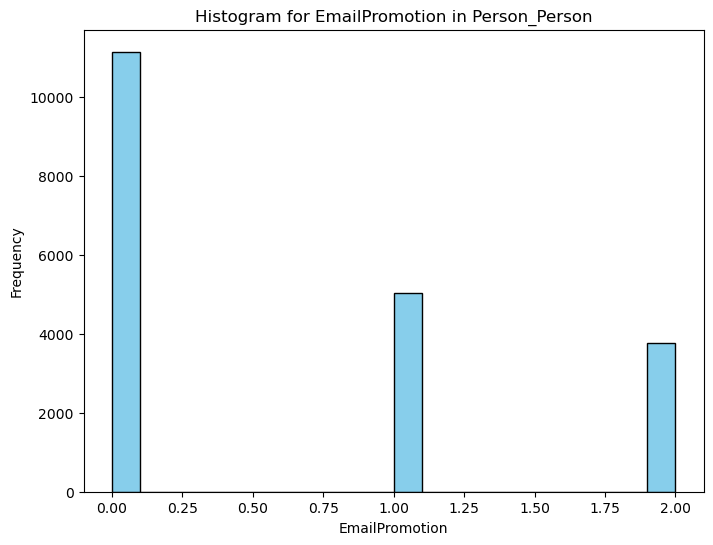





QUERY
------
 SELECT BusinessEntityID, PhoneNumber, PhoneNumberTypeID, ModifiedDate FROM Person.PersonPhone 
 ----------------------------------------------
Schema: Person
Table: PersonPhone

   BusinessEntityID   PhoneNumber  PhoneNumberTypeID ModifiedDate
0                 1  697-555-0142                  1   2009-01-07
1                 2  819-555-0175                  3   2008-01-24
2                 3  212-555-0187                  1   2007-11-04
3                 4  612-555-0100                  1   2007-11-28
4                 5  849-555-0139                  1   2007-12-30

Statistical Information:
       BusinessEntityID  PhoneNumberTypeID                   ModifiedDate
count      19972.000000       19972.000000                          19972
mean       10763.079411           1.531344  2013-05-18 10:25:58.388290816
min            1.000000           1.000000            2006-06-23 00:00:00
25%         5798.750000           1.000000            2012-12-12 00:00:00
50%        1

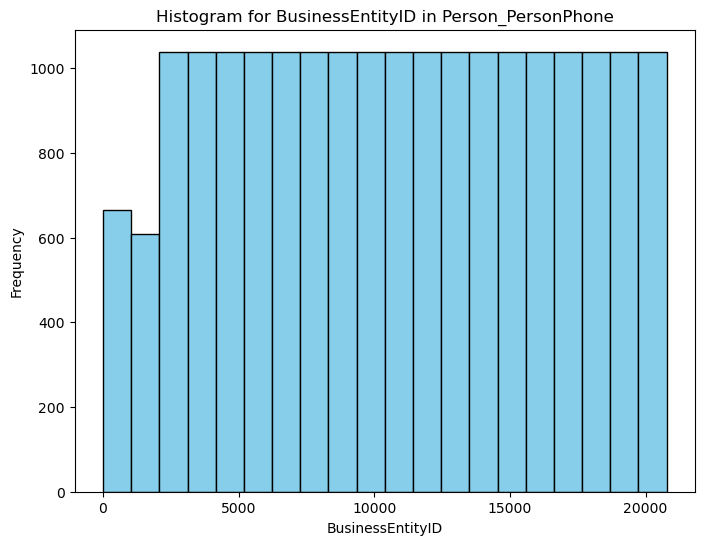

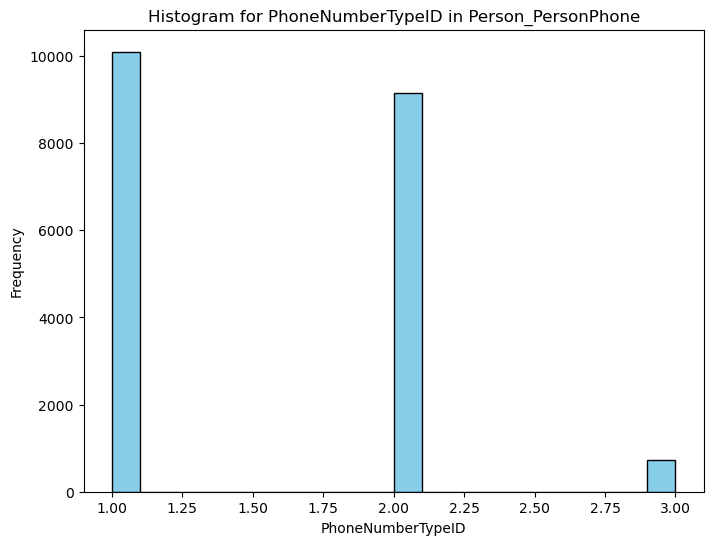





QUERY
------
 SELECT PhoneNumberTypeID, Name, ModifiedDate FROM Person.PhoneNumberType 
 ----------------------------------------------
Schema: Person
Table: PhoneNumberType

   PhoneNumberTypeID  Name            ModifiedDate
0                  1  Cell 2017-12-13 13:19:22.273
1                  2  Home 2017-12-13 13:19:22.273
2                  3  Work 2017-12-13 13:19:22.273

Statistical Information:
       PhoneNumberTypeID                   ModifiedDate
count                3.0                              3
mean                 2.0  2017-12-13 13:19:22.272999936
min                  1.0     2017-12-13 13:19:22.273000
25%                  1.5  2017-12-13 13:19:22.272999936
50%                  2.0  2017-12-13 13:19:22.272999936
75%                  2.5  2017-12-13 13:19:22.272999936
max                  3.0     2017-12-13 13:19:22.273000
std                  1.0                            NaN


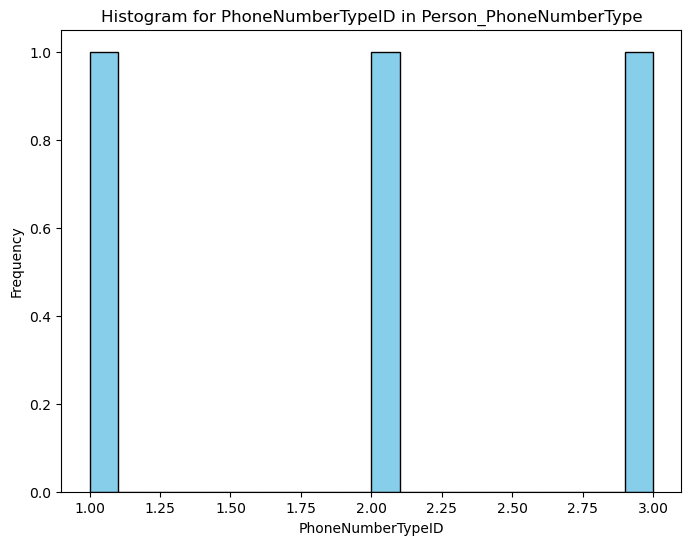





QUERY
------
 SELECT StateProvinceID, StateProvinceCode, CountryRegionCode, IsOnlyStateProvinceFlag, Name, TerritoryID, rowguid, ModifiedDate FROM Person.StateProvince 
 ----------------------------------------------
Schema: Person
Table: StateProvince

   StateProvinceID StateProvinceCode CountryRegionCode  \
0                1               AB                 CA   
1                2               AK                 US   
2                3               AL                 US   
3                4               AR                 US   
4                5               AS                 AS   

   IsOnlyStateProvinceFlag            Name  TerritoryID  \
0                    False         Alberta            6   
1                    False          Alaska            1   
2                    False         Alabama            5   
3                    False        Arkansas            3   
4                     True  American Samoa            1   

                                rowgui

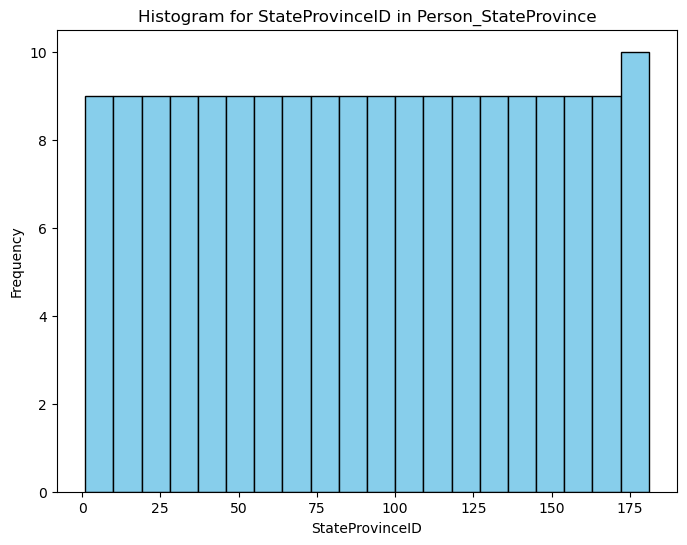

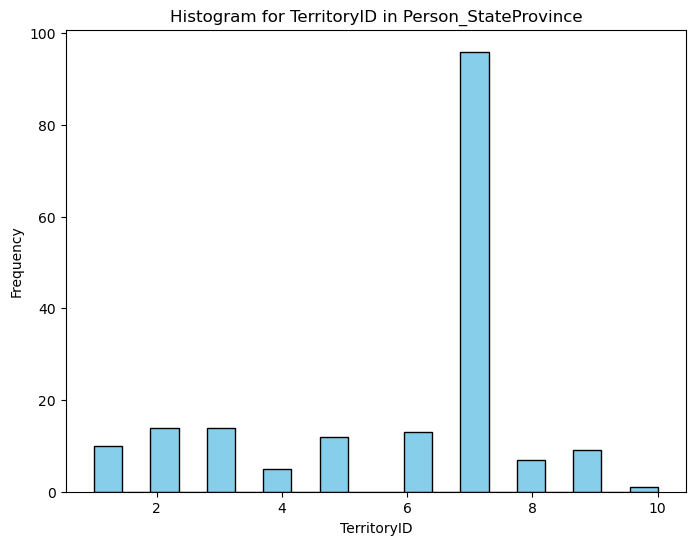





QUERY
------
 SELECT CountryRegionCode, CurrencyCode, ModifiedDate FROM Sales.CountryRegionCurrency 
 ----------------------------------------------
Schema: Sales
Table: CountryRegionCurrency

  CountryRegionCode CurrencyCode            ModifiedDate
0                AE          AED 2014-02-08 10:17:21.510
1                AR          ARS 2014-02-08 10:17:21.510
2                AT          ATS 2014-02-08 10:17:21.510
3                AT          EUR 2008-04-30 00:00:00.000
4                AU          AUD 2014-02-08 10:17:21.510

Statistical Information:
                        ModifiedDate
count                            109
mean   2013-07-29 19:28:25.591652096
min              2008-04-30 00:00:00
25%    2014-02-08 10:17:21.510000128
50%    2014-02-08 10:17:21.510000128
75%    2014-02-08 10:17:21.510000128
max       2014-02-08 10:17:21.510000




QUERY
------
 SELECT CreditCardID, CardType, CardNumber, ExpMonth, ExpYear, ModifiedDate FROM Sales.CreditCard 
 ----------------------

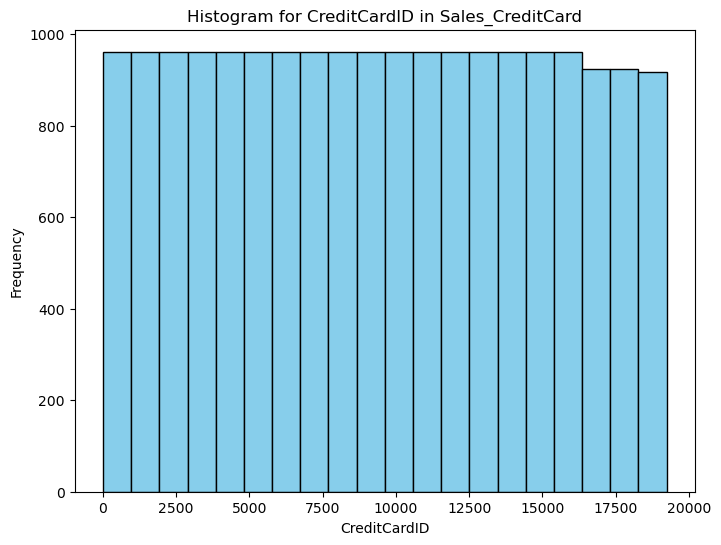

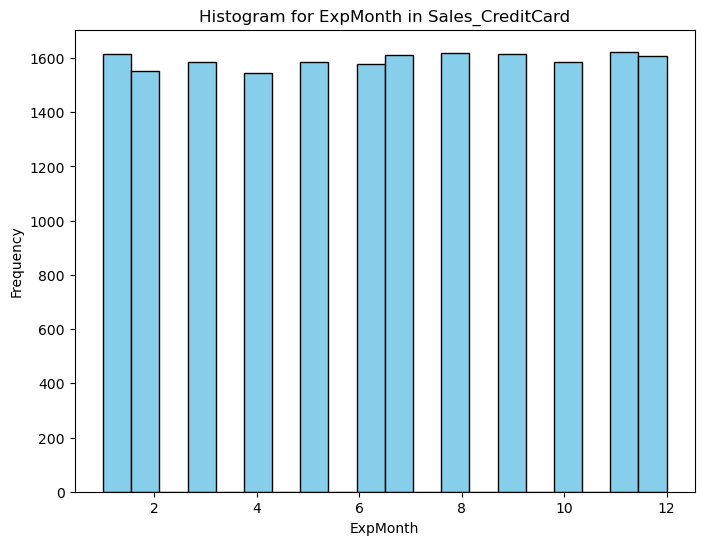

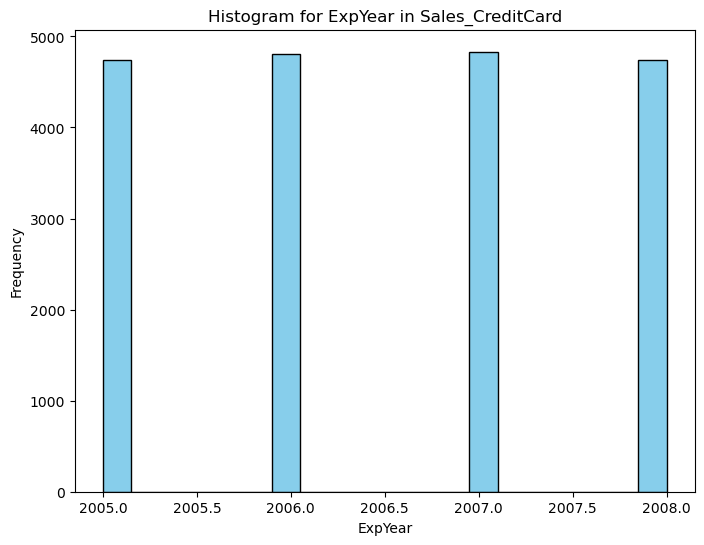





QUERY
------
 SELECT CurrencyCode, Name, ModifiedDate FROM Sales.Currency 
 ----------------------------------------------
Schema: Sales
Table: Currency

  CurrencyCode                           Name ModifiedDate
0          AED                 Emirati Dirham   2008-04-30
1          AFA                        Afghani   2008-04-30
2          ALL                            Lek   2008-04-30
3          AMD                  Armenian Dram   2008-04-30
4          ANG  Netherlands Antillian Guilder   2008-04-30

Statistical Information:
              ModifiedDate
count                  105
mean   2008-04-30 00:00:00
min    2008-04-30 00:00:00
25%    2008-04-30 00:00:00
50%    2008-04-30 00:00:00
75%    2008-04-30 00:00:00
max    2008-04-30 00:00:00




QUERY
------
 SELECT CurrencyRateID, CurrencyRateDate, FromCurrencyCode, ToCurrencyCode, AverageRate, EndOfDayRate, ModifiedDate FROM Sales.CurrencyRate 
 ----------------------------------------------
Schema: Sales
Table: CurrencyRate

   Cu

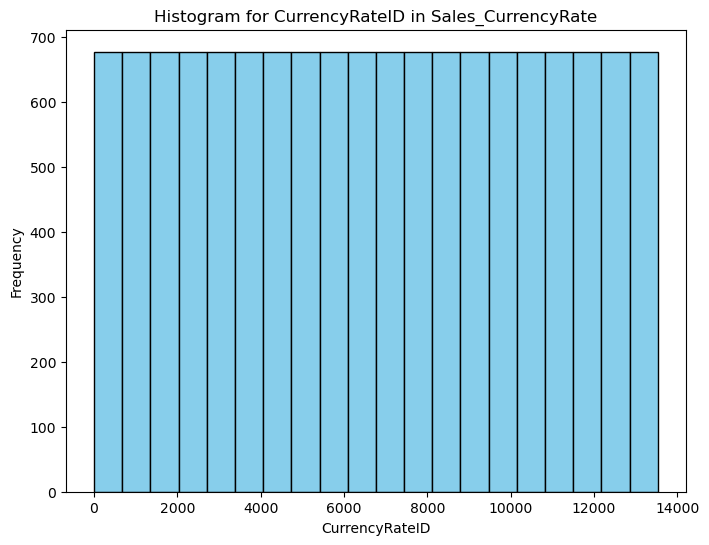

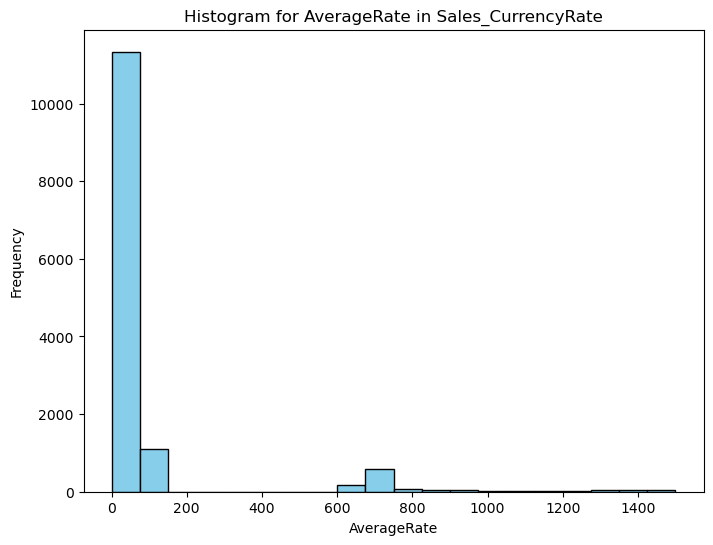

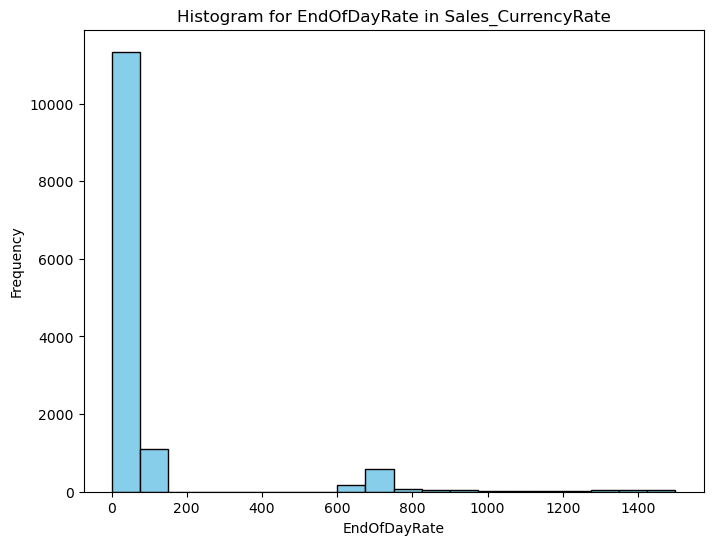





QUERY
------
 SELECT CustomerID, PersonID, StoreID, TerritoryID, AccountNumber, rowguid, ModifiedDate FROM Sales.Customer 
 ----------------------------------------------
Schema: Sales
Table: Customer

   CustomerID  PersonID  StoreID  TerritoryID AccountNumber  \
0           1       NaN    934.0            1    AW00000001   
1           2       NaN   1028.0            1    AW00000002   
2           3       NaN    642.0            4    AW00000003   
3           4       NaN    932.0            4    AW00000004   
4           5       NaN   1026.0            4    AW00000005   

                                rowguid            ModifiedDate  
0  3F5AE95E-B87D-4AED-95B4-C3797AFCB74F 2014-09-12 11:15:07.263  
1  E552F657-A9AF-4A7D-A645-C429D6E02491 2014-09-12 11:15:07.263  
2  130774B1-DB21-4EF3-98C8-C104BCD6ED6D 2014-09-12 11:15:07.263  
3  FF862851-1DAA-4044-BE7C-3E85583C054D 2014-09-12 11:15:07.263  
4  83905BDC-6F5E-4F71-B162-C98DA069F38A 2014-09-12 11:15:07.263  

Statistical Inform

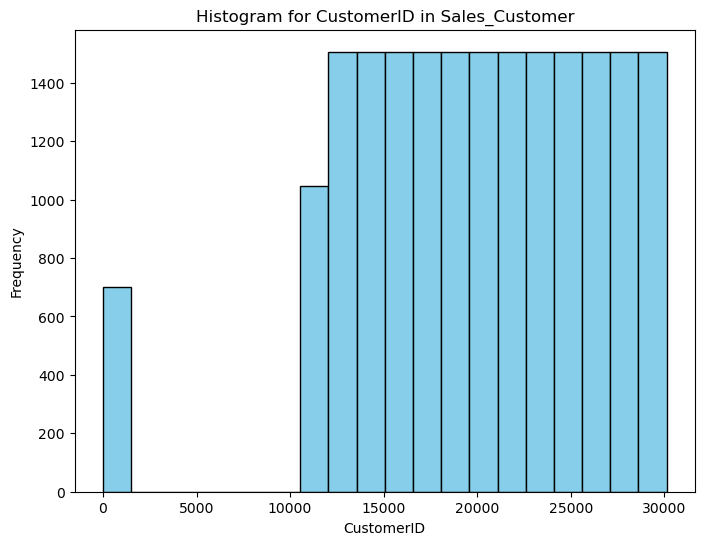

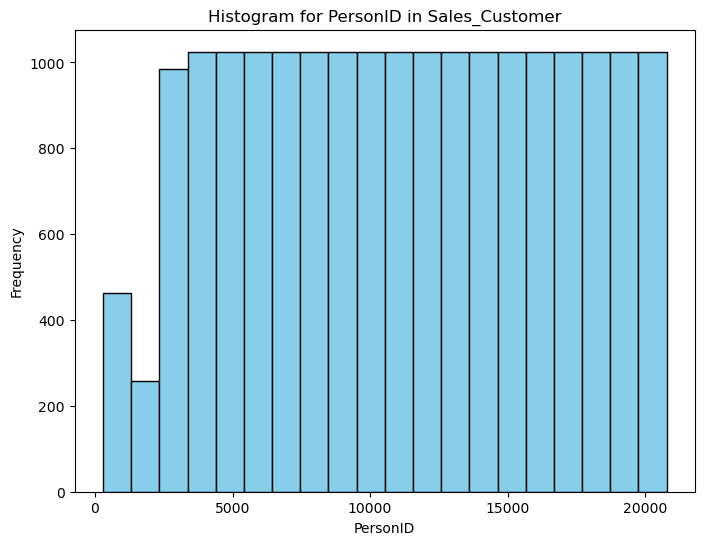

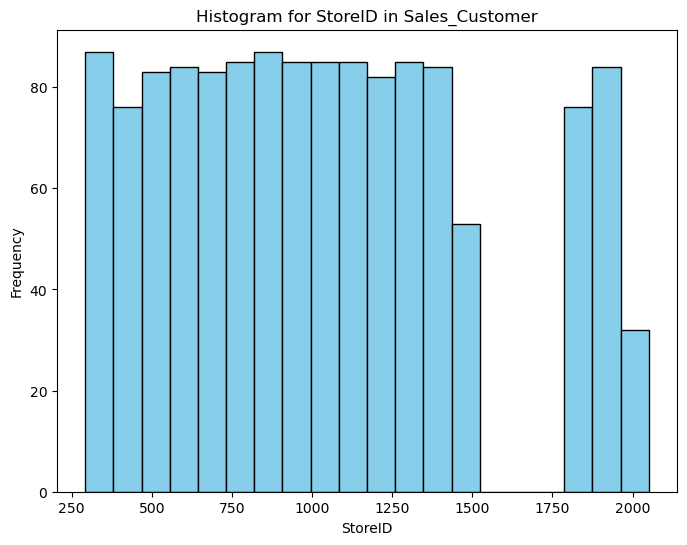

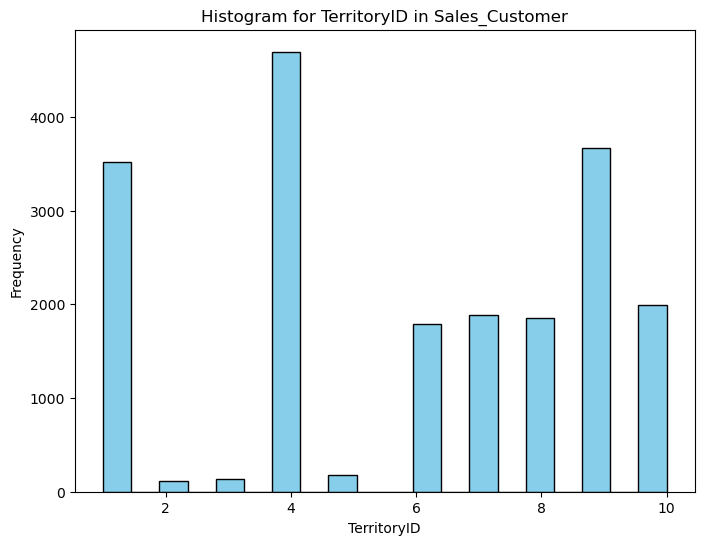





QUERY
------
 SELECT BusinessEntityID, CreditCardID, ModifiedDate FROM Sales.PersonCreditCard 
 ----------------------------------------------
Schema: Sales
Table: PersonCreditCard

   BusinessEntityID  CreditCardID ModifiedDate
0               293         17038   2013-07-31
1               295         15369   2011-08-01
2               297          8010   2011-08-01
3               299          5316   2013-07-31
4               301          6653   2011-05-31

Statistical Information:
       BusinessEntityID  CreditCardID                   ModifiedDate
count      19118.000000  19118.000000                          19118
mean       11184.760017   9567.669526  2013-07-06 05:08:58.173449216
min          293.000000      1.000000            2011-05-31 00:00:00
25%         6439.250000   4780.250000            2013-02-13 00:00:00
50%        11218.500000   9559.500000            2013-09-25 00:00:00
75%        15997.750000  14338.750000            2014-02-05 00:00:00
max        20777.000000

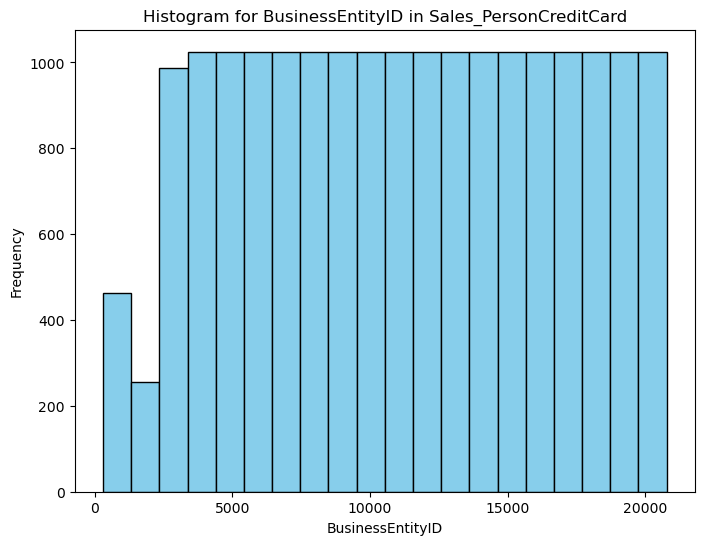

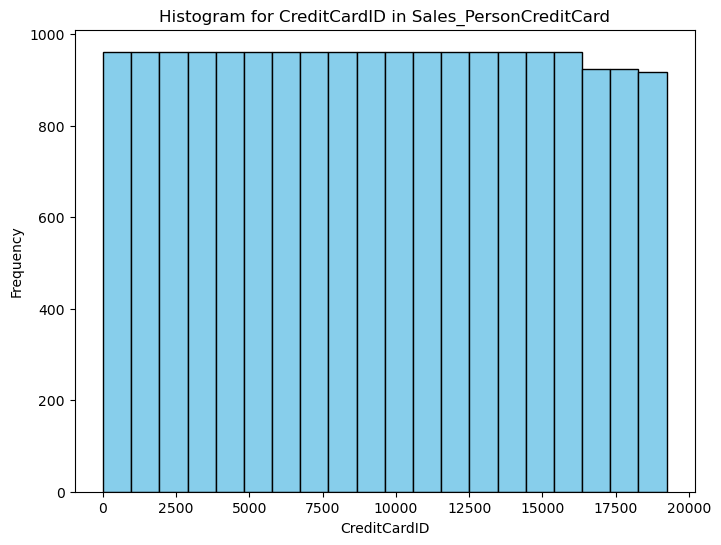





QUERY
------
 SELECT SalesOrderID, SalesOrderDetailID, CarrierTrackingNumber, OrderQty, ProductID, SpecialOfferID, UnitPrice, UnitPriceDiscount, LineTotal, rowguid, ModifiedDate FROM Sales.SalesOrderDetail 
 ----------------------------------------------
Schema: Sales
Table: SalesOrderDetail

   SalesOrderID  SalesOrderDetailID CarrierTrackingNumber  OrderQty  \
0         43659                   1          4911-403C-98         1   
1         43659                   2          4911-403C-98         3   
2         43659                   3          4911-403C-98         1   
3         43659                   4          4911-403C-98         1   
4         43659                   5          4911-403C-98         1   

   ProductID  SpecialOfferID  UnitPrice  UnitPriceDiscount  LineTotal  \
0        776               1   2024.994                0.0   2024.994   
1        777               1   2024.994                0.0   6074.982   
2        778               1   2024.994                0

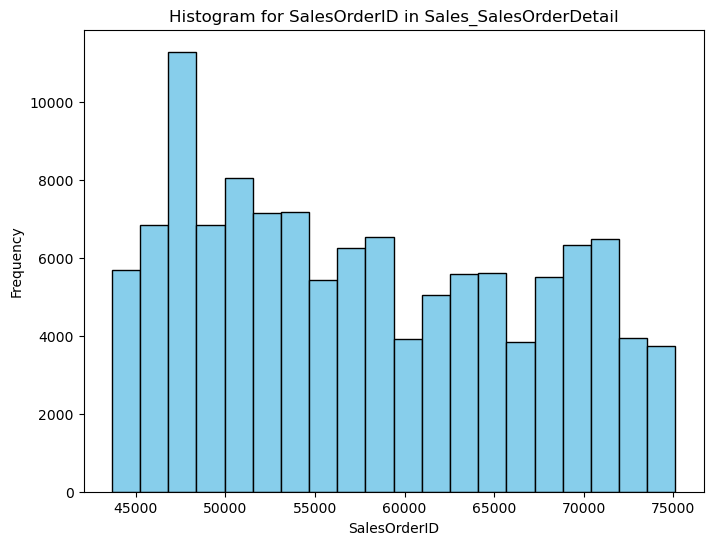

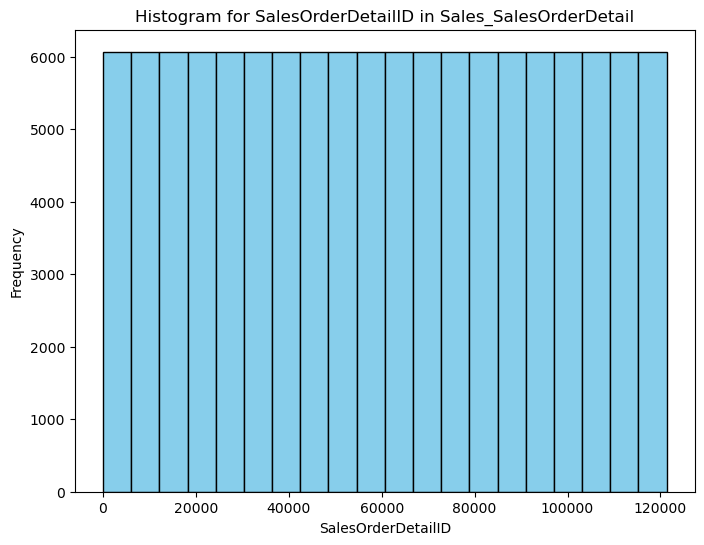

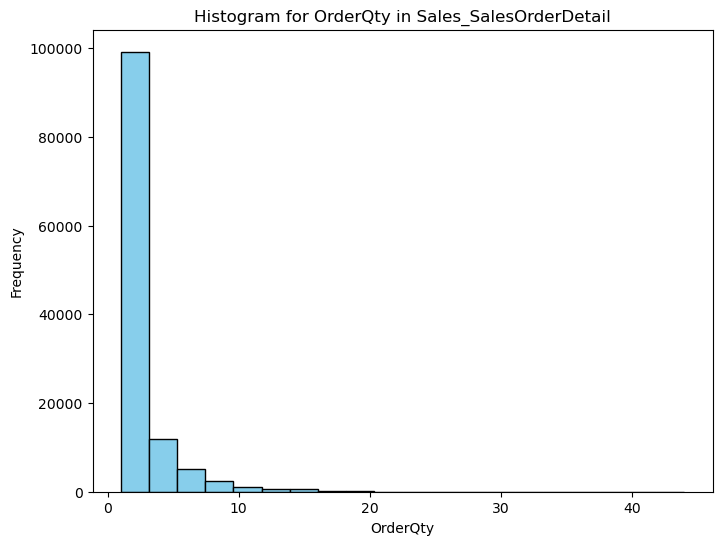

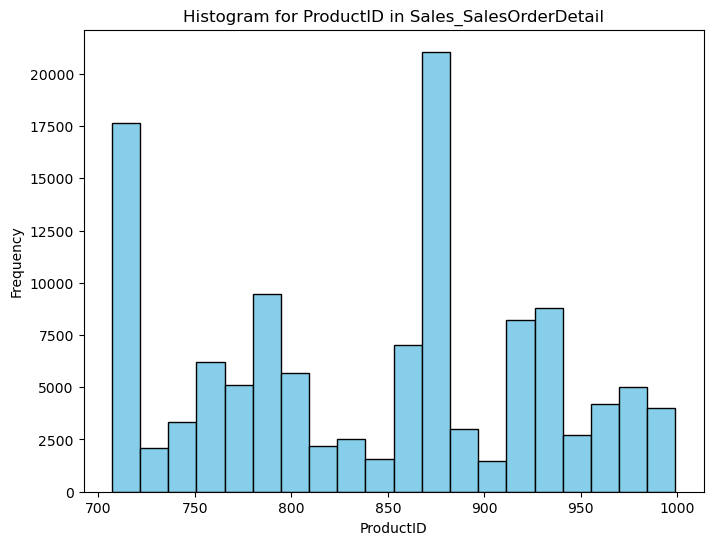

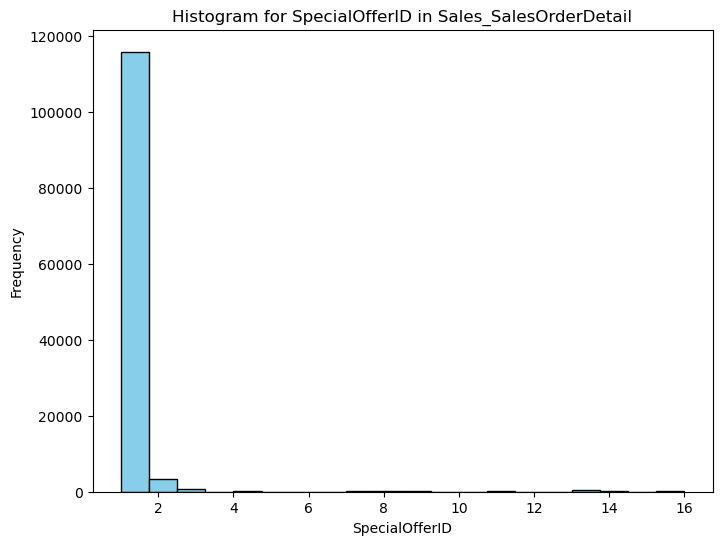

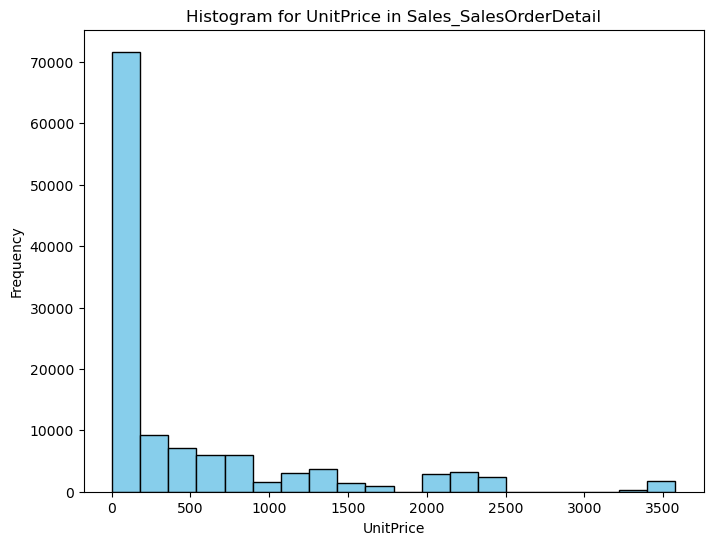

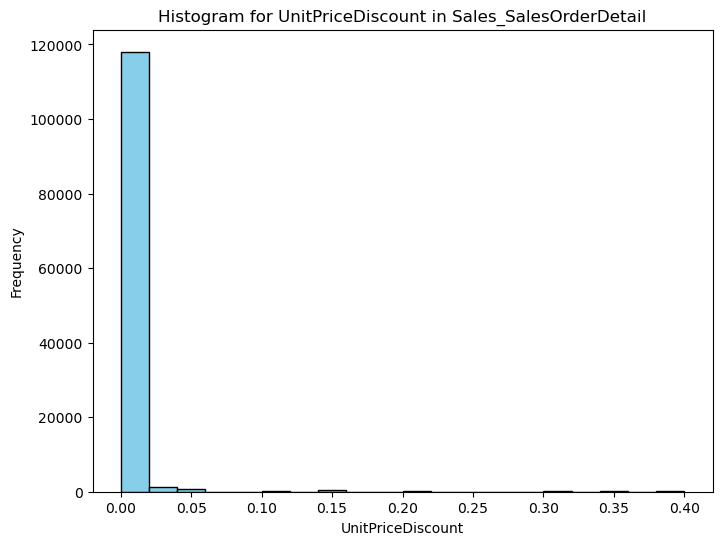

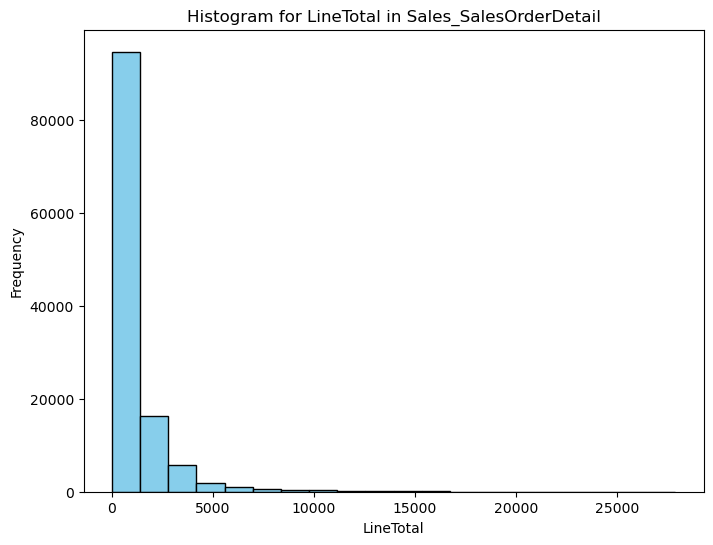





QUERY
------
 SELECT SalesOrderID, RevisionNumber, OrderDate, DueDate, ShipDate, Status, OnlineOrderFlag, SalesOrderNumber, PurchaseOrderNumber, AccountNumber, CustomerID, SalesPersonID, TerritoryID, BillToAddressID, ShipToAddressID, ShipMethodID, CreditCardID, CreditCardApprovalCode, CurrencyRateID, SubTotal, TaxAmt, Freight, TotalDue, Comment, rowguid, ModifiedDate FROM Sales.SalesOrderHeader 
 ----------------------------------------------
Schema: Sales
Table: SalesOrderHeader

   SalesOrderID  RevisionNumber  OrderDate    DueDate   ShipDate  Status  \
0         43659               8 2011-05-31 2011-06-12 2011-06-07       5   
1         43660               8 2011-05-31 2011-06-12 2011-06-07       5   
2         43661               8 2011-05-31 2011-06-12 2011-06-07       5   
3         43662               8 2011-05-31 2011-06-12 2011-06-07       5   
4         43663               8 2011-05-31 2011-06-12 2011-06-07       5   

   OnlineOrderFlag SalesOrderNumber PurchaseOrderNumb

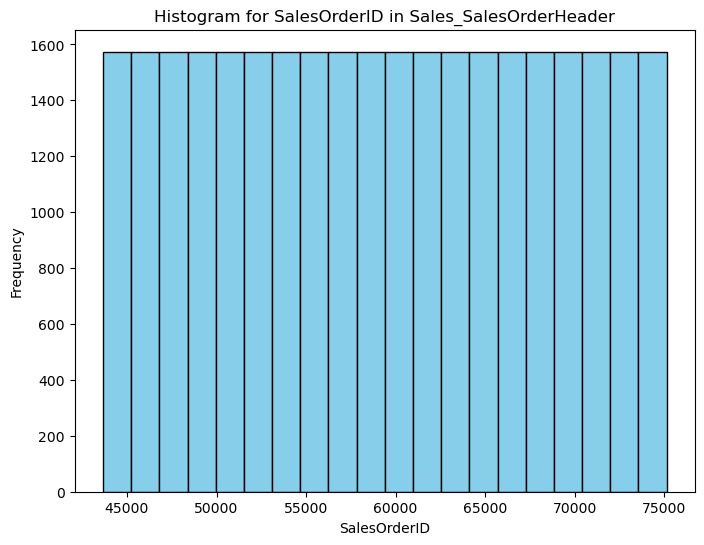

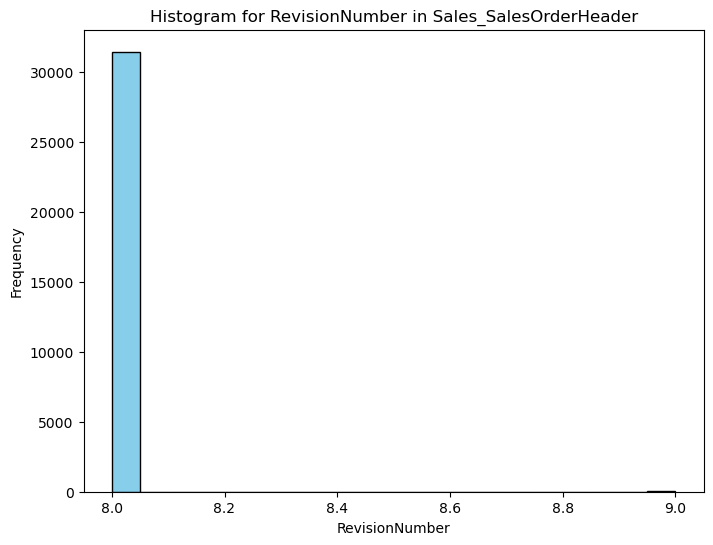

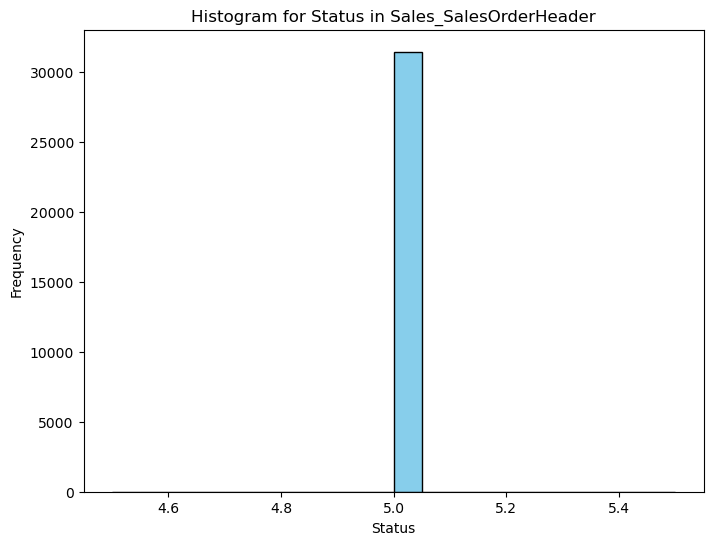

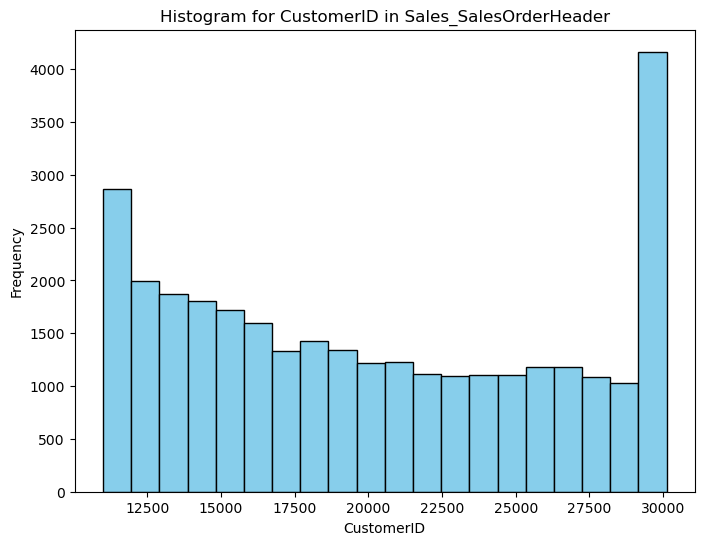

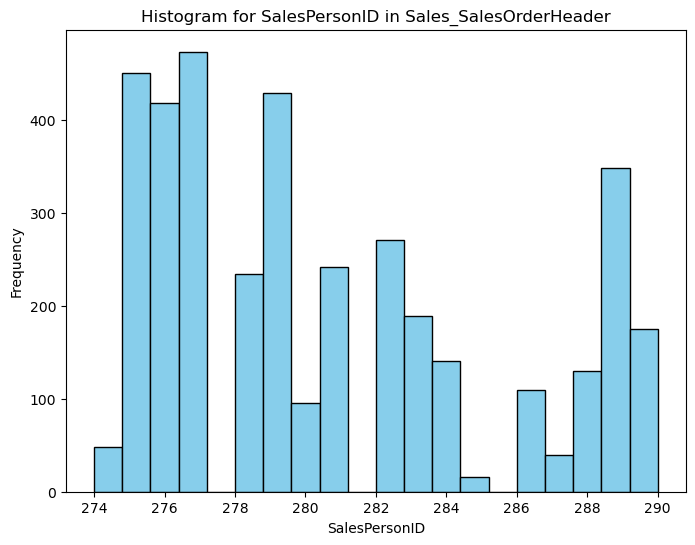

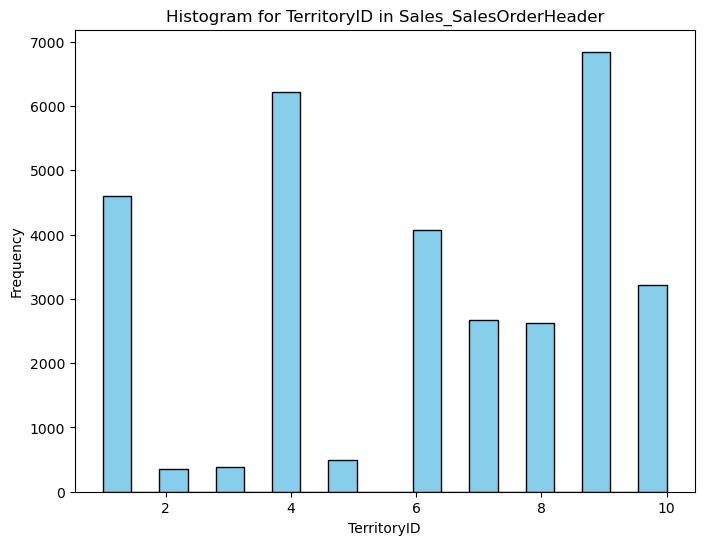

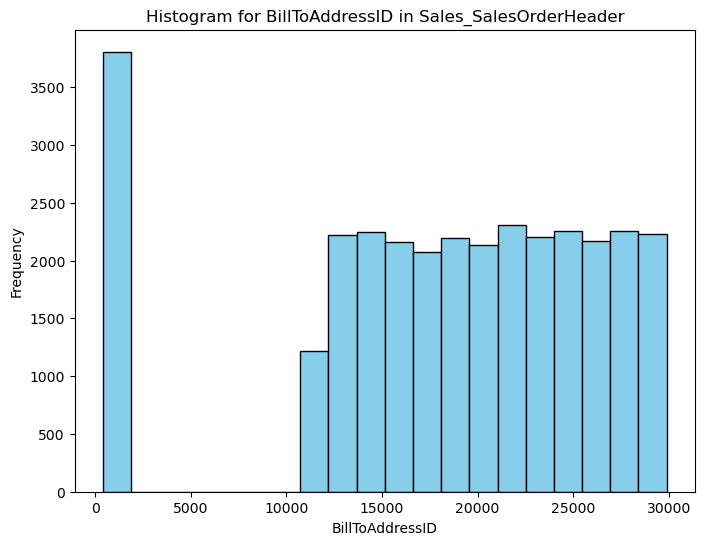

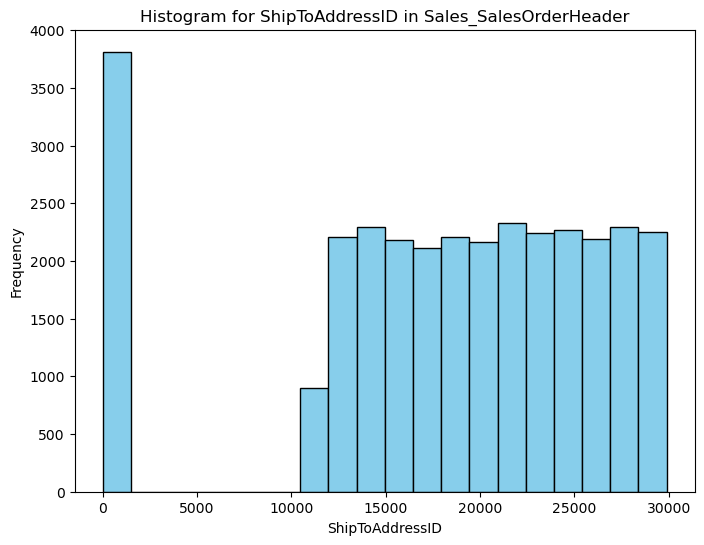

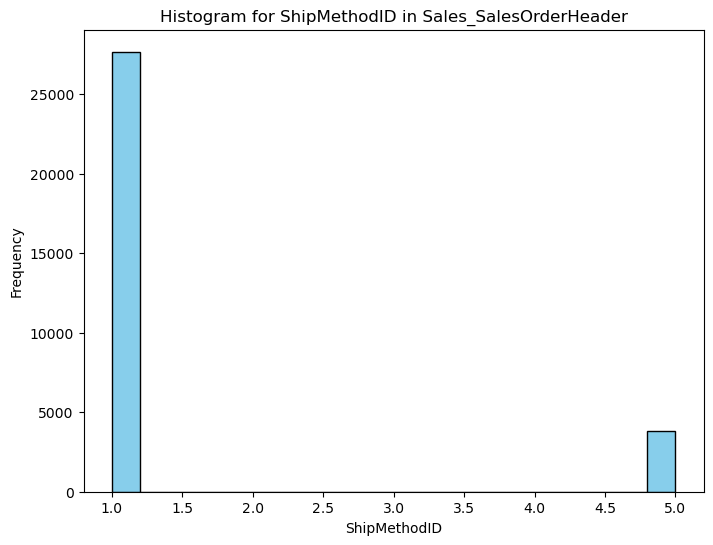

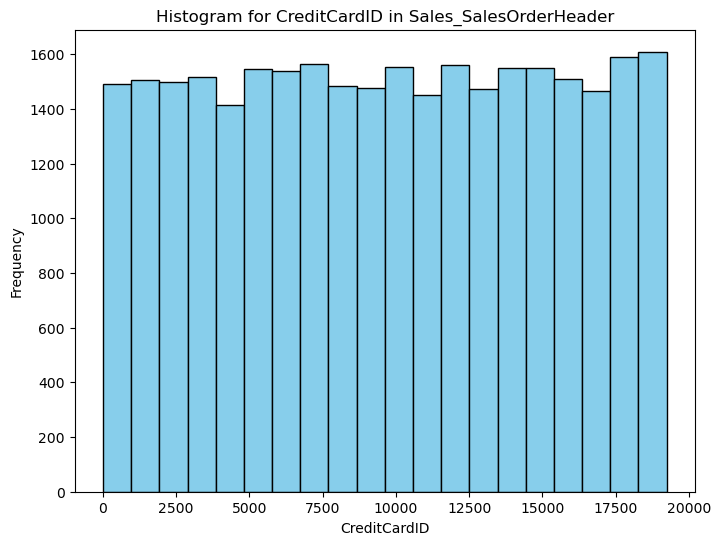

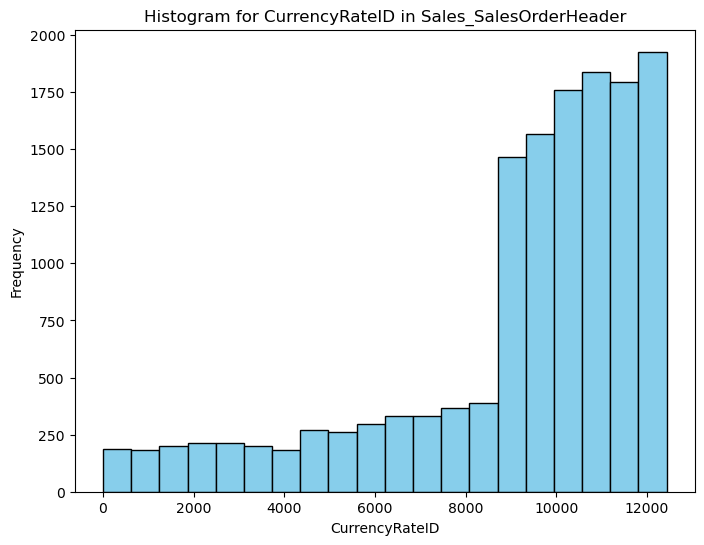

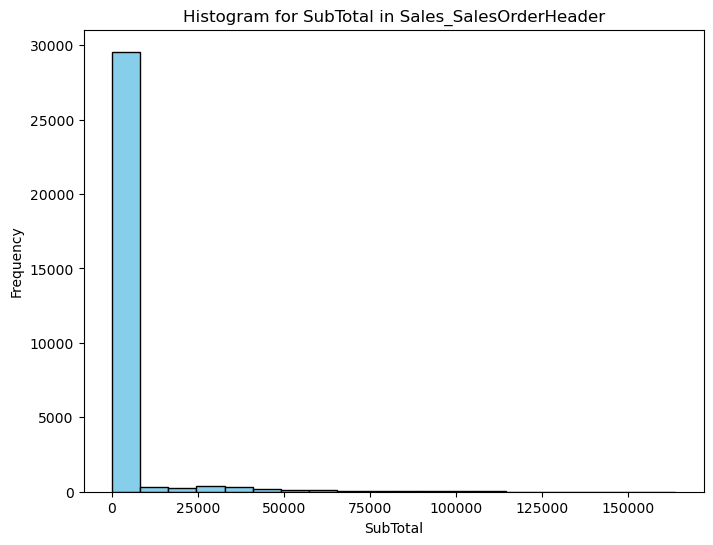

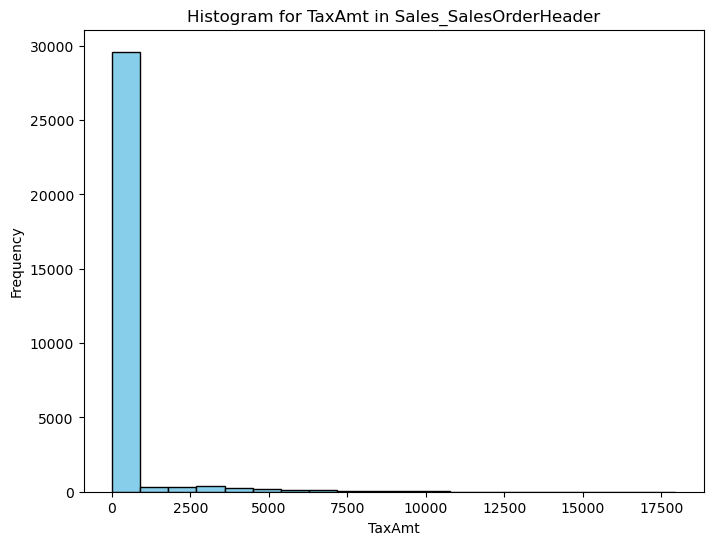

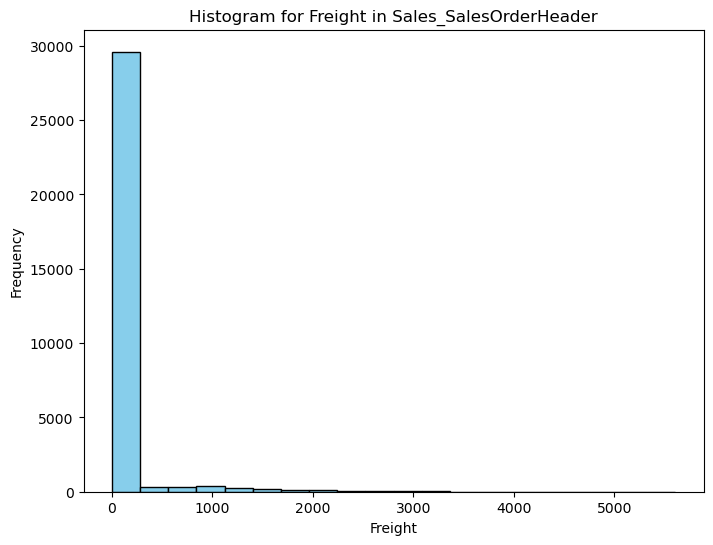

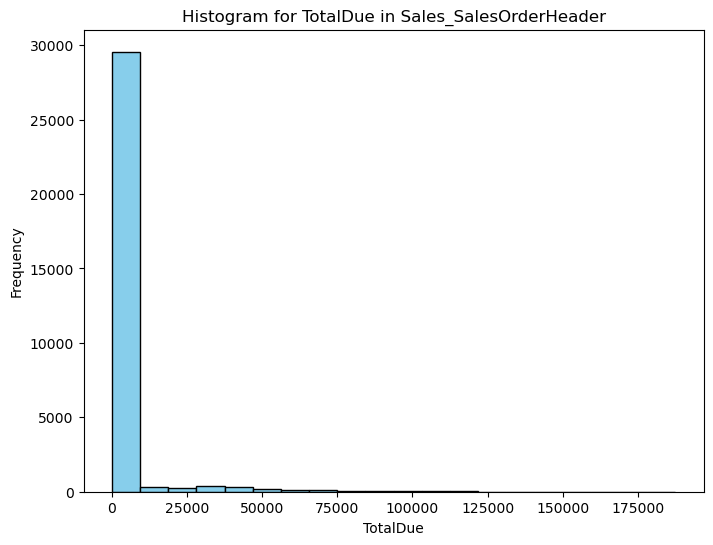





QUERY
------
 SELECT SalesOrderID, SalesReasonID, ModifiedDate FROM Sales.SalesOrderHeaderSalesReason 
 ----------------------------------------------
Schema: Sales
Table: SalesOrderHeaderSalesReason

   SalesOrderID  SalesReasonID ModifiedDate
0         43697              5   2011-05-31
1         43697              9   2011-05-31
2         43702              5   2011-06-01
3         43702              9   2011-06-01
4         43703              5   2011-06-01

Statistical Information:
       SalesOrderID  SalesReasonID                   ModifiedDate
count  27647.000000   27647.000000                          27647
mean   60458.862589       2.586176  2013-09-13 16:11:17.107823616
min    43697.000000       1.000000            2011-05-31 00:00:00
25%    53756.500000       1.000000            2013-08-02 00:00:00
50%    60852.000000       1.000000            2013-11-25 00:00:00
75%    68039.000000       2.000000            2014-03-11 00:00:00
max    75123.000000      10.000000         

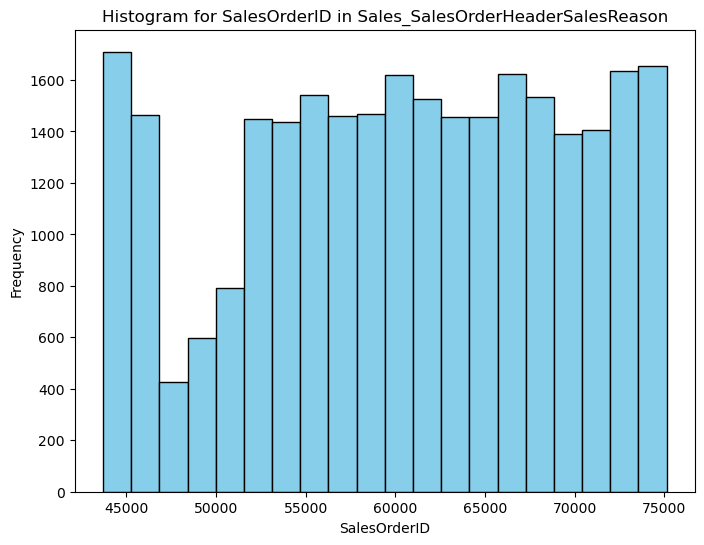

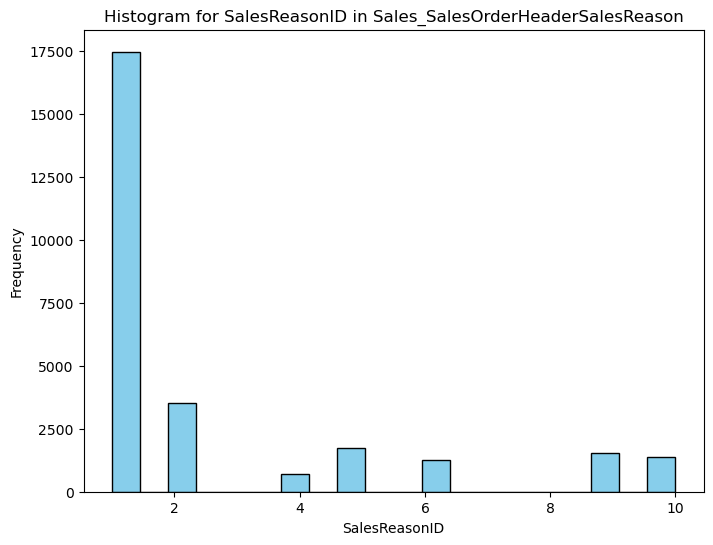





QUERY
------
 SELECT BusinessEntityID, TerritoryID, SalesQuota, Bonus, CommissionPct, SalesYTD, SalesLastYear, rowguid, ModifiedDate FROM Sales.SalesPerson 
 ----------------------------------------------
Schema: Sales
Table: SalesPerson

   BusinessEntityID  TerritoryID  SalesQuota   Bonus  CommissionPct  \
0               274          NaN         NaN     0.0          0.000   
1               275          2.0    300000.0  4100.0          0.012   
2               276          4.0    250000.0  2000.0          0.015   
3               277          3.0    250000.0  2500.0          0.015   
4               278          6.0    250000.0   500.0          0.010   

       SalesYTD  SalesLastYear                               rowguid  \
0  5.596976e+05   0.000000e+00  48754992-9EE0-4C0E-8C94-9451604E3E02   
1  3.763178e+06   1.750406e+06  1E0A7274-3064-4F58-88EE-4C6586C87169   
2  4.251369e+06   1.439156e+06  4DD9EEE4-8E81-4F8C-AF97-683394C1F7C0   
3  3.189418e+06   1.997186e+06  39012928-B

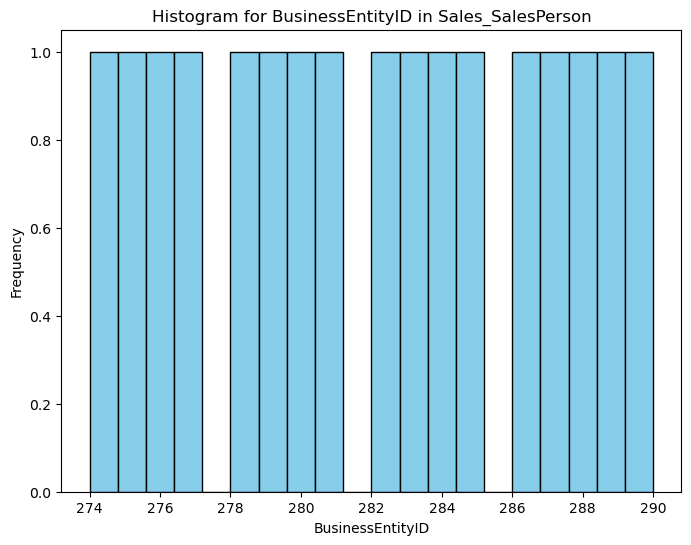

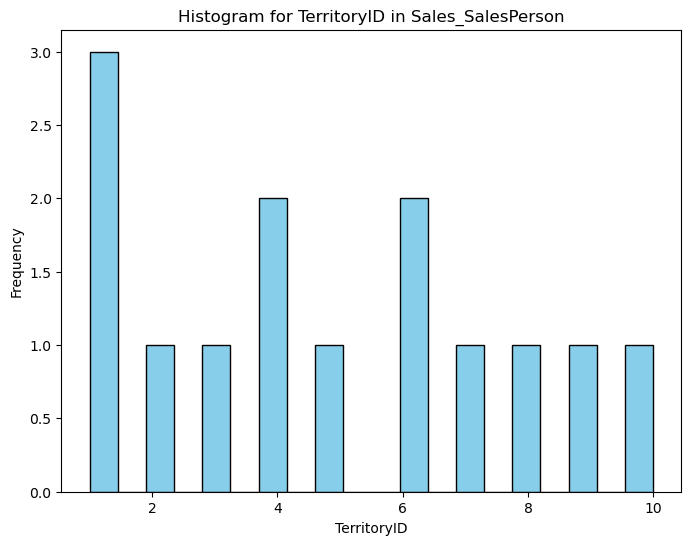

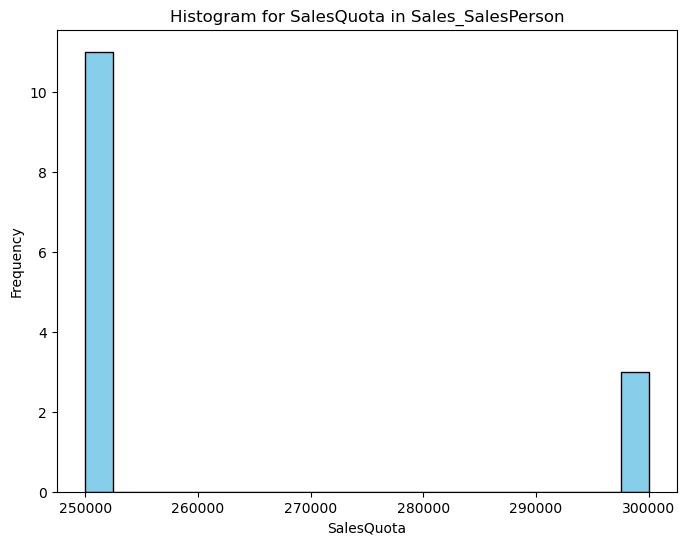

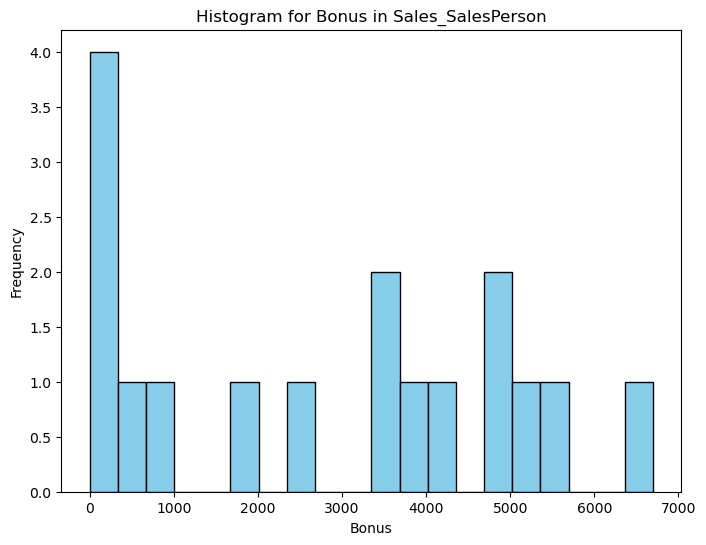

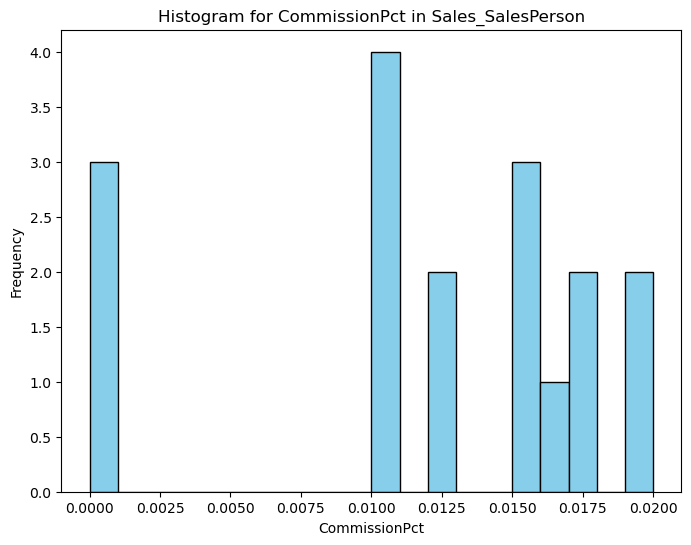

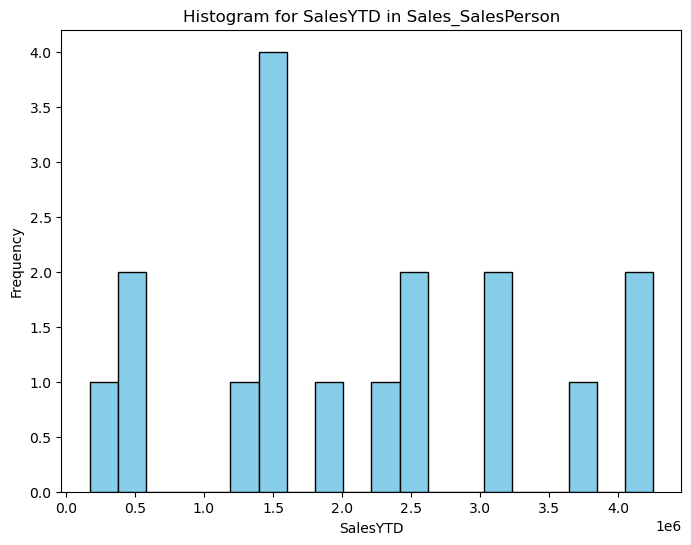

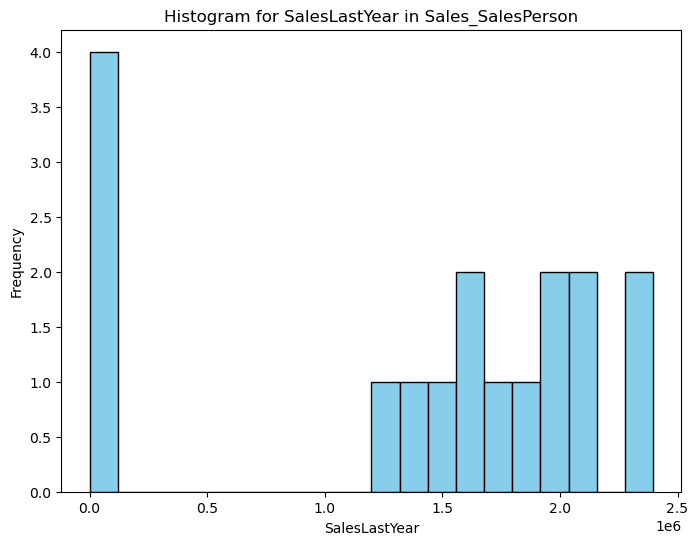





QUERY
------
 SELECT BusinessEntityID, QuotaDate, SalesQuota, rowguid, ModifiedDate FROM Sales.SalesPersonQuotaHistory 
 ----------------------------------------------
Schema: Sales
Table: SalesPersonQuotaHistory

   BusinessEntityID  QuotaDate  SalesQuota  \
0               274 2011-05-31     28000.0   
1               274 2011-08-31      7000.0   
2               274 2011-12-01     91000.0   
3               274 2012-02-29    140000.0   
4               274 2012-05-30     70000.0   

                                rowguid ModifiedDate  
0  99109BBF-8693-4587-BC23-6036EC89E1BE   2011-04-16  
1  DFD01444-8900-461C-8D6F-04598DAE01D4   2011-07-17  
2  0A69F453-9689-4CCF-A08C-C644670F5668   2011-10-17  
3  DA8D1458-5FB9-4C3E-9EAD-8F5CE1393047   2012-01-15  
4  760CEF84-B980-417B-A667-7358C38857F0   2012-04-15  

Statistical Information:
       BusinessEntityID                      QuotaDate    SalesQuota  \
count        163.000000                            163  1.630000e+02   
mean 

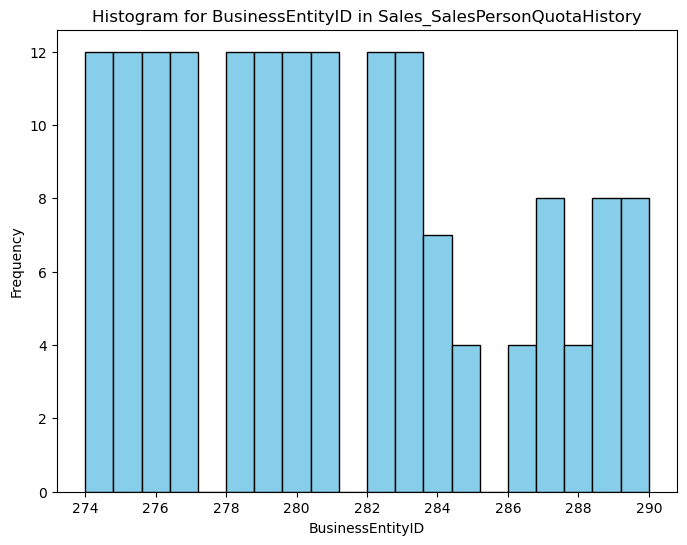

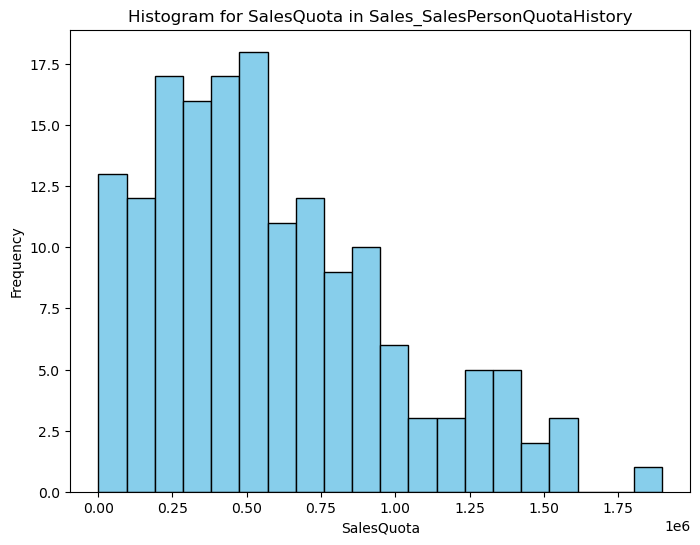





QUERY
------
 SELECT SalesReasonID, Name, ReasonType, ModifiedDate FROM Sales.SalesReason 
 ----------------------------------------------
Schema: Sales
Table: SalesReason

   SalesReasonID                       Name ReasonType ModifiedDate
0              1                      Price      Other   2008-04-30
1              2               On Promotion  Promotion   2008-04-30
2              3     Magazine Advertisement  Marketing   2008-04-30
3              4  Television  Advertisement  Marketing   2008-04-30
4              5               Manufacturer      Other   2008-04-30

Statistical Information:
       SalesReasonID         ModifiedDate
count       10.00000                   10
mean         5.50000  2008-04-30 00:00:00
min          1.00000  2008-04-30 00:00:00
25%          3.25000  2008-04-30 00:00:00
50%          5.50000  2008-04-30 00:00:00
75%          7.75000  2008-04-30 00:00:00
max         10.00000  2008-04-30 00:00:00
std          3.02765                  NaN


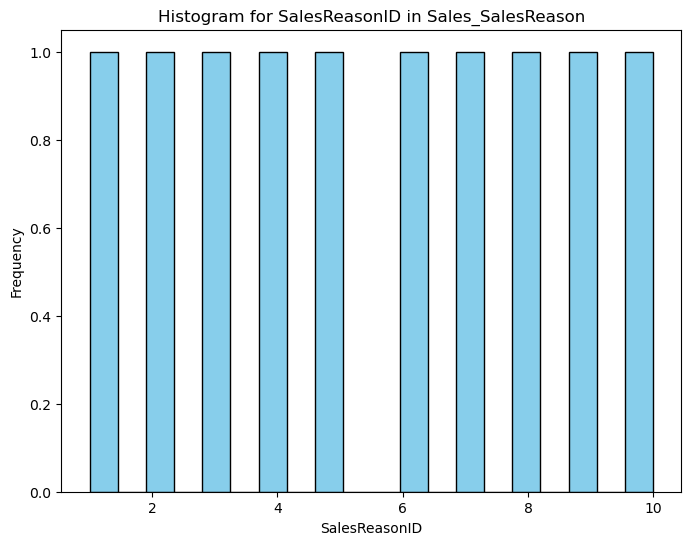





QUERY
------
 SELECT SalesTaxRateID, StateProvinceID, TaxType, TaxRate, Name, rowguid, ModifiedDate FROM Sales.SalesTaxRate 
 ----------------------------------------------
Schema: Sales
Table: SalesTaxRate

   SalesTaxRateID  StateProvinceID  TaxType  TaxRate  \
0               1                1        1    14.00   
1               2               57        1    14.25   
2               3               63        1    14.25   
3               4                1        2     7.00   
4               5               57        2     7.00   

                                    Name  \
0  Canadian GST + Alberta Provincial Tax   
1  Canadian GST + Ontario Provincial Tax   
2   Canadian GST + Quebec Provincial Tax   
3                           Canadian GST   
4                           Canadian GST   

                                rowguid ModifiedDate  
0  683DE5DD-521A-47D4-A573-06A3CDB1BC5D   2008-04-30  
1  05C4FFDB-4F84-4CDF-ABE5-FDF3216EA74E   2008-04-30  
2  D4EDB557-56D7-403C

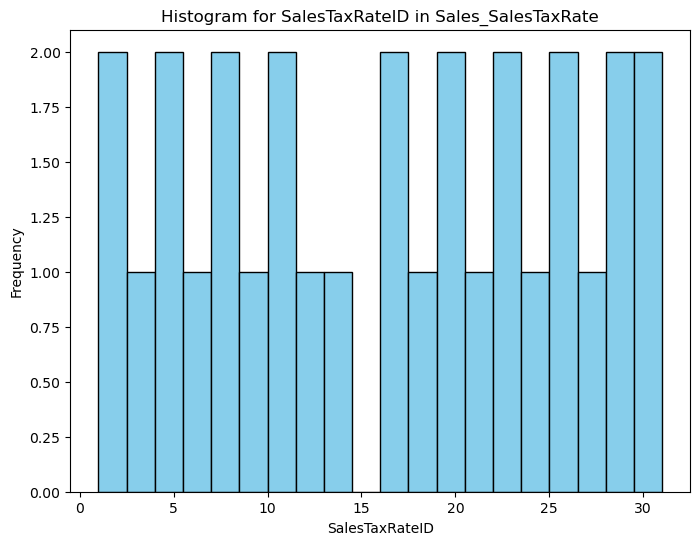

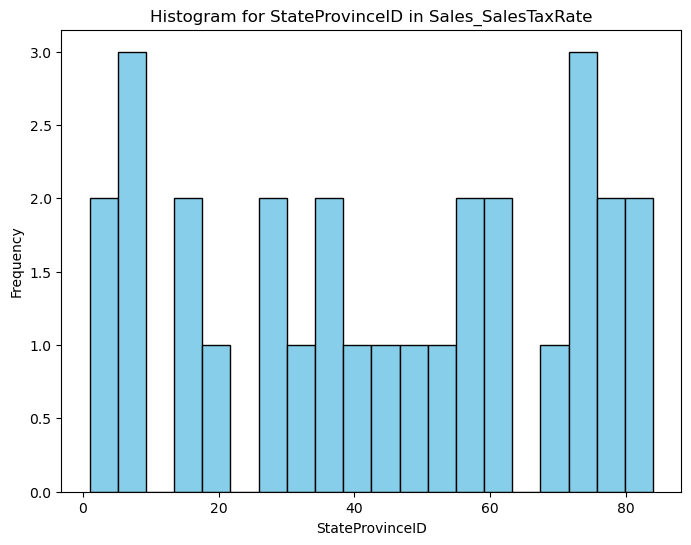

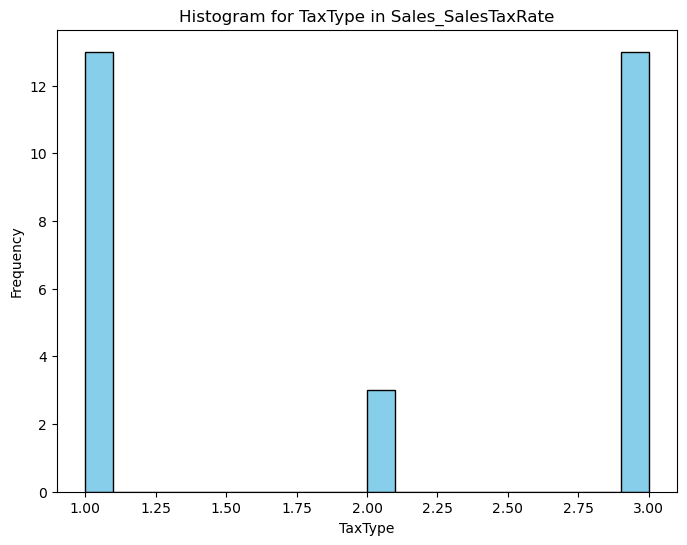

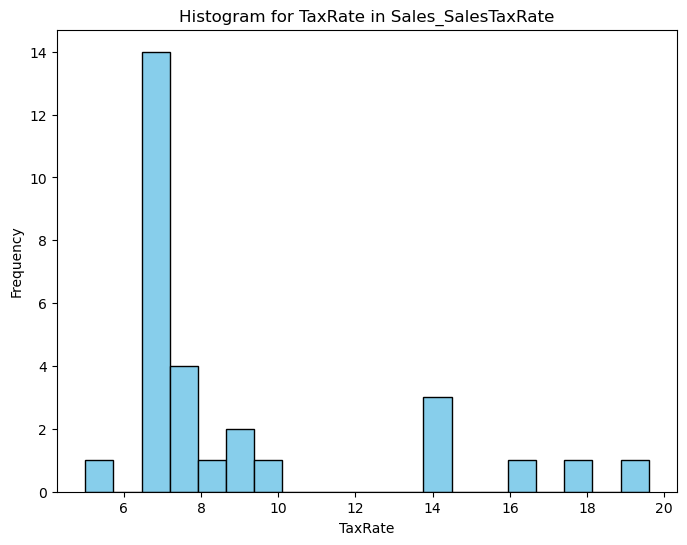





QUERY
------
 SELECT TerritoryID, Name, CountryRegionCode, Group, SalesYTD, SalesLastYear, CostYTD, CostLastYear, rowguid, ModifiedDate FROM Sales.SalesTerritory 
 ----------------------------------------------
Error executing query: (pyodbc.ProgrammingError) ('42000', "[42000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Incorrect syntax near the keyword 'Group'. (156) (SQLExecDirectW)")
[SQL: SELECT TerritoryID, Name, CountryRegionCode, Group, SalesYTD, SalesLastYear, CostYTD, CostLastYear, rowguid, ModifiedDate FROM Sales.SalesTerritory]
(Background on this error at: https://sqlalche.me/e/14/f405)




QUERY
------
 SELECT BusinessEntityID, TerritoryID, StartDate, EndDate, rowguid, ModifiedDate FROM Sales.SalesTerritoryHistory 
 ----------------------------------------------
Schema: Sales
Table: SalesTerritoryHistory

   BusinessEntityID  TerritoryID  StartDate    EndDate  \
0               275            2 2011-05-31 2012-11-29   
1               275            3 2012-1

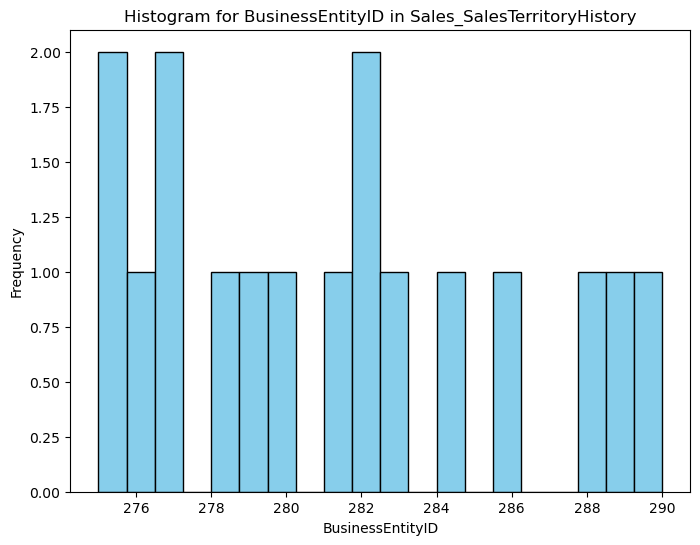

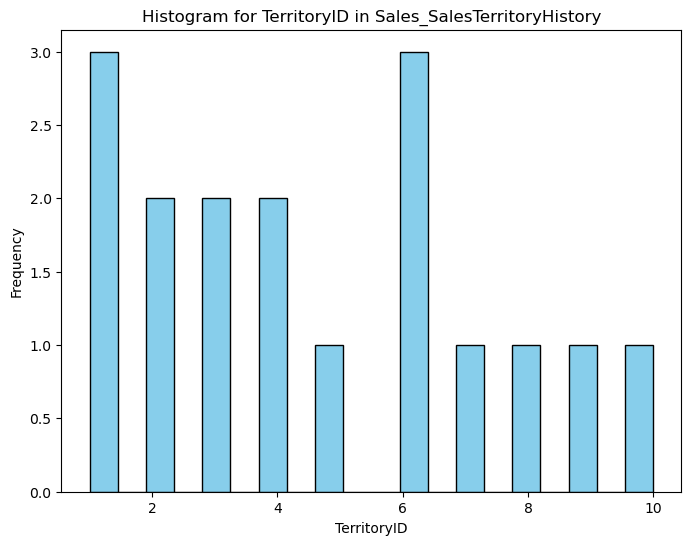





QUERY
------
 SELECT ShoppingCartItemID, ShoppingCartID, Quantity, ProductID, DateCreated, ModifiedDate FROM Sales.ShoppingCartItem 
 ----------------------------------------------
Schema: Sales
Table: ShoppingCartItem

   ShoppingCartItemID ShoppingCartID  Quantity  ProductID  \
0                   2          14951         3        862   
1                   4          20621         4        881   
2                   5          20621         7        874   

              DateCreated            ModifiedDate  
0 2013-11-09 17:54:07.603 2013-11-09 17:54:07.603  
1 2013-11-09 17:54:07.603 2013-11-09 17:54:07.603  
2 2013-11-09 17:54:07.603 2013-11-09 17:54:07.603  

Statistical Information:
       ShoppingCartItemID  Quantity   ProductID  \
count            3.000000  3.000000    3.000000   
mean             3.666667  4.666667  872.333333   
min              2.000000  3.000000  862.000000   
25%              3.000000  3.500000  868.000000   
50%              4.000000  4.000000  874.0

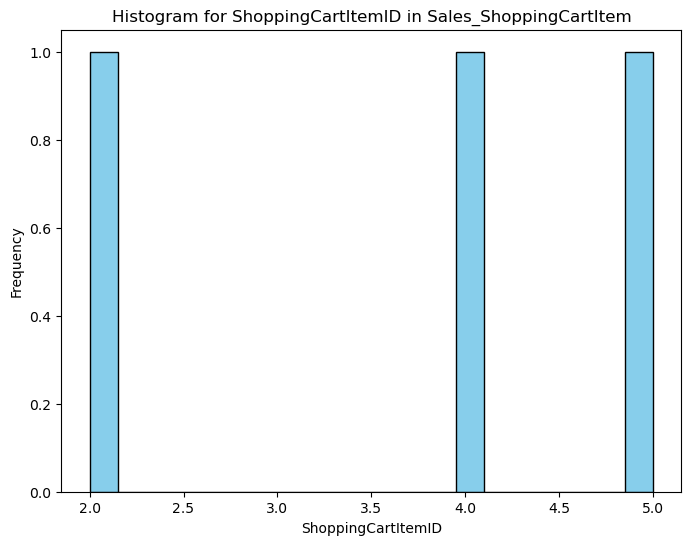

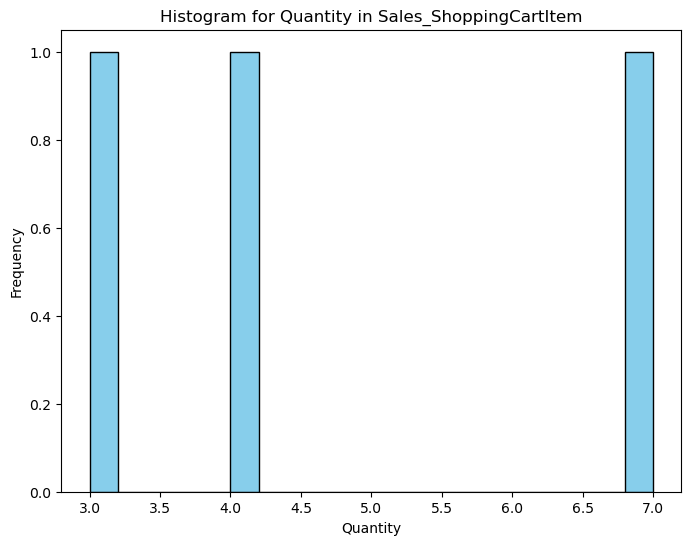

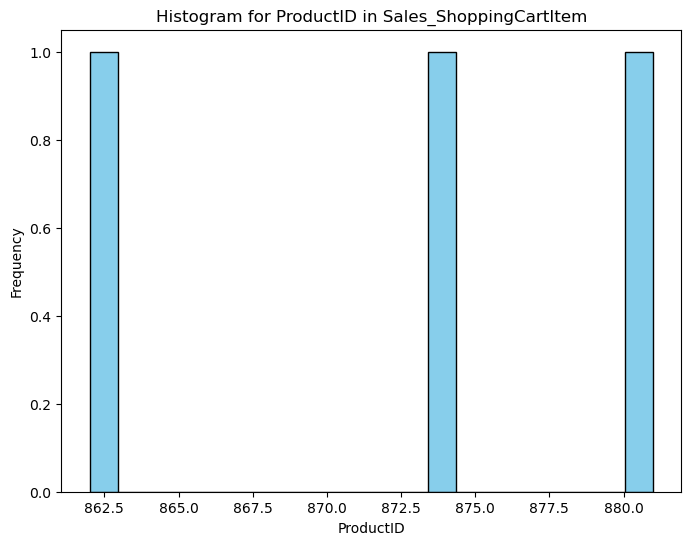





QUERY
------
 SELECT SpecialOfferID, Description, DiscountPct, Type, Category, StartDate, EndDate, MinQty, MaxQty, rowguid, ModifiedDate FROM Sales.SpecialOffer 
 ----------------------------------------------
Schema: Sales
Table: SpecialOffer

   SpecialOfferID               Description  DiscountPct             Type  \
0               1               No Discount         0.00      No Discount   
1               2  Volume Discount 11 to 14         0.02  Volume Discount   
2               3  Volume Discount 15 to 24         0.05  Volume Discount   
3               4  Volume Discount 25 to 40         0.10  Volume Discount   
4               5  Volume Discount 41 to 60         0.15  Volume Discount   

      Category  StartDate    EndDate  MinQty  MaxQty  \
0  No Discount 2011-05-01 2014-11-30       0     NaN   
1     Reseller 2011-05-31 2014-05-30      11    14.0   
2     Reseller 2011-05-31 2014-05-30      15    24.0   
3     Reseller 2011-05-31 2014-05-30      25    40.0   
4     Re

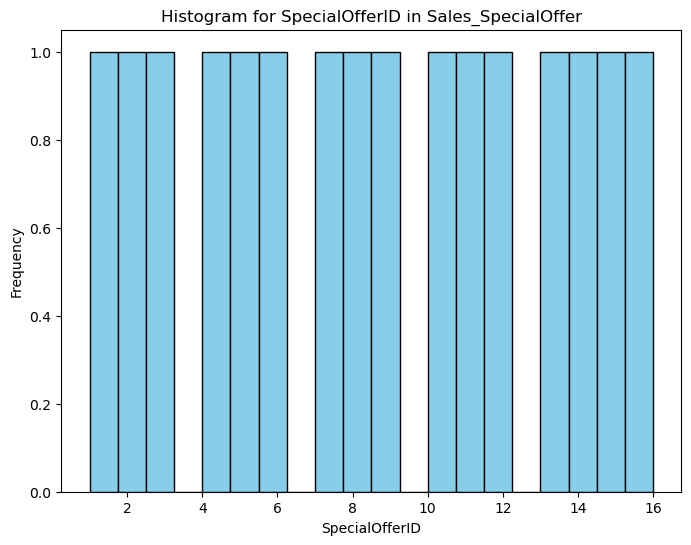

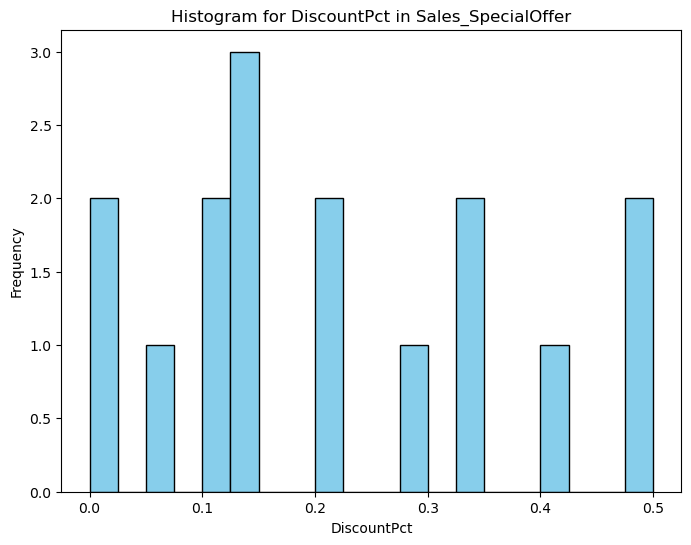

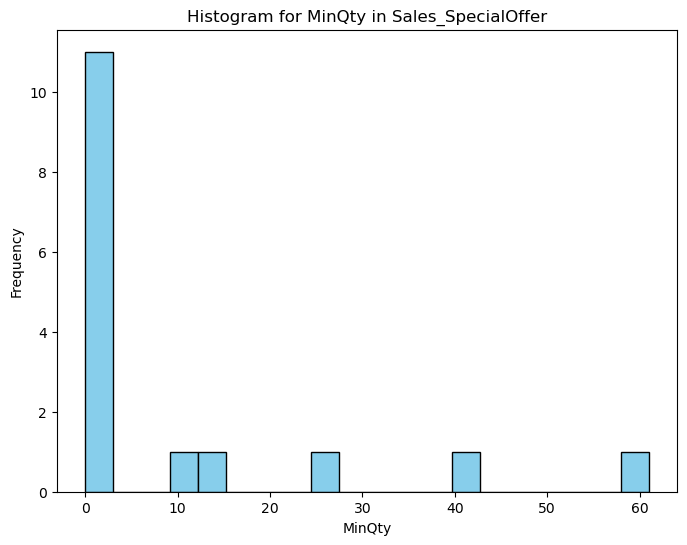

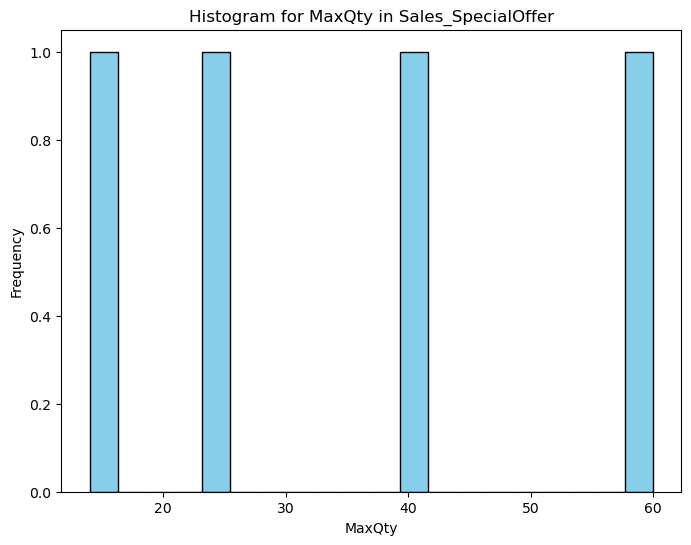





QUERY
------
 SELECT SpecialOfferID, ProductID, rowguid, ModifiedDate FROM Sales.SpecialOfferProduct 
 ----------------------------------------------
Schema: Sales
Table: SpecialOfferProduct

   SpecialOfferID  ProductID                               rowguid  \
0               1        680  BB30B868-D86C-4557-8DB2-4B2D0A83A0FB   
1               1        706  B3C9A4B1-2AE6-4CBA-B552-1F206C9F4C1F   
2               1        707  27B711FE-0B77-4EA4-AD1A-7C239956BEF4   
3               1        708  46CBB78B-246E-4D69-9BD6-E521277C1078   
4               1        709  CF102AA0-055F-4D2B-8B98-04B161758EA8   

  ModifiedDate  
0   2011-04-01  
1   2011-04-01  
2   2011-04-01  
3   2011-04-01  
4   2011-04-01  

Statistical Information:
       SpecialOfferID   ProductID                   ModifiedDate
count      538.000000  538.000000                            538
mean         2.711896  849.470260  2011-06-27 20:57:59.553903360
min          1.000000  680.000000            2011-04-01 00:0

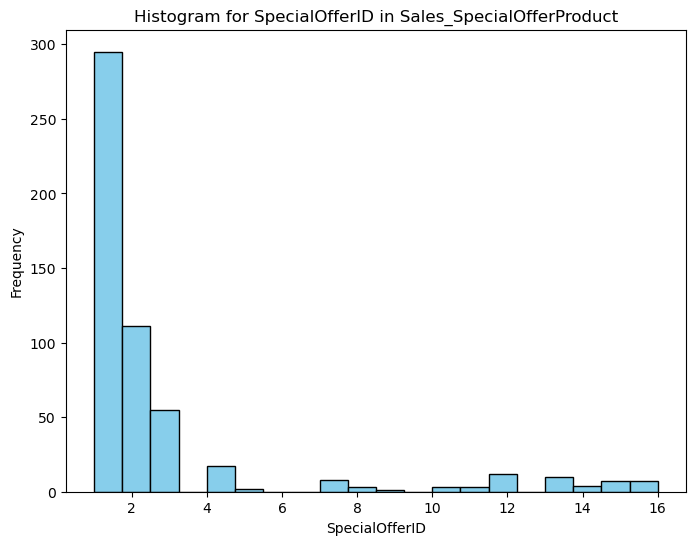

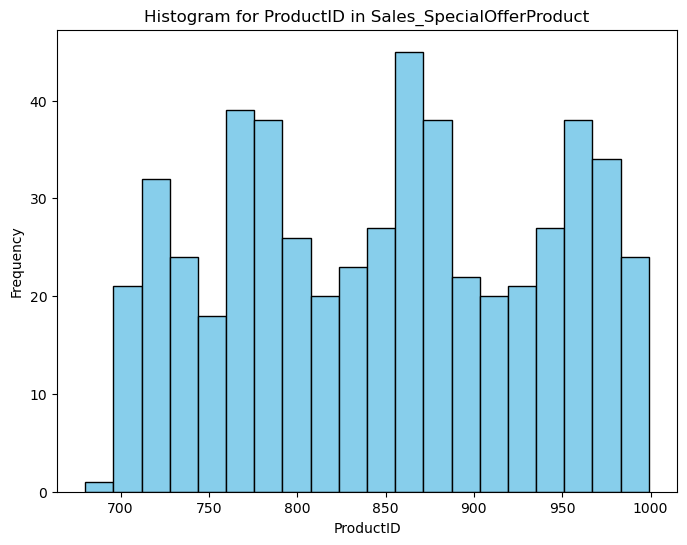





QUERY
------
 SELECT BusinessEntityID, Name, SalesPersonID, Demographics, rowguid, ModifiedDate FROM Sales.Store 
 ----------------------------------------------
Schema: Sales
Table: Store

   BusinessEntityID                            Name  SalesPersonID  \
0               292            Next-Door Bike Store            279   
1               294  Professional Sales and Service            276   
2               296                  Riders Company            277   
3               298              The Bike Mechanics            275   
4               300               Nationwide Supply            286   

                                        Demographics  \
0  <StoreSurvey xmlns="http://schemas.microsoft.c...   
1  <StoreSurvey xmlns="http://schemas.microsoft.c...   
2  <StoreSurvey xmlns="http://schemas.microsoft.c...   
3  <StoreSurvey xmlns="http://schemas.microsoft.c...   
4  <StoreSurvey xmlns="http://schemas.microsoft.c...   

                                rowguid         

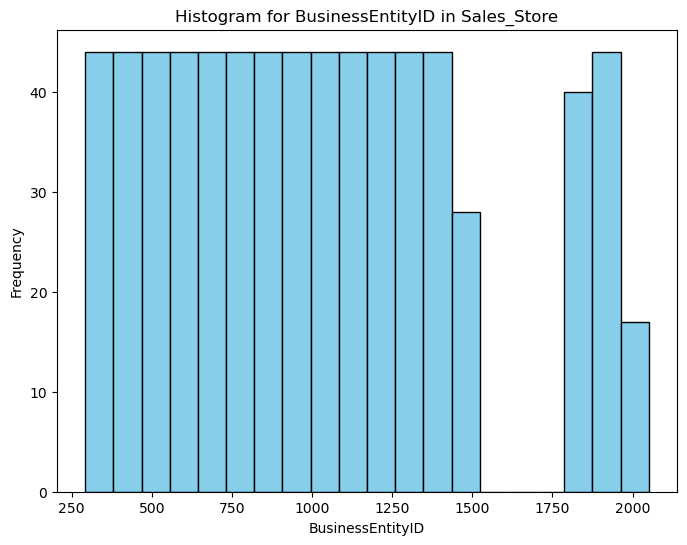

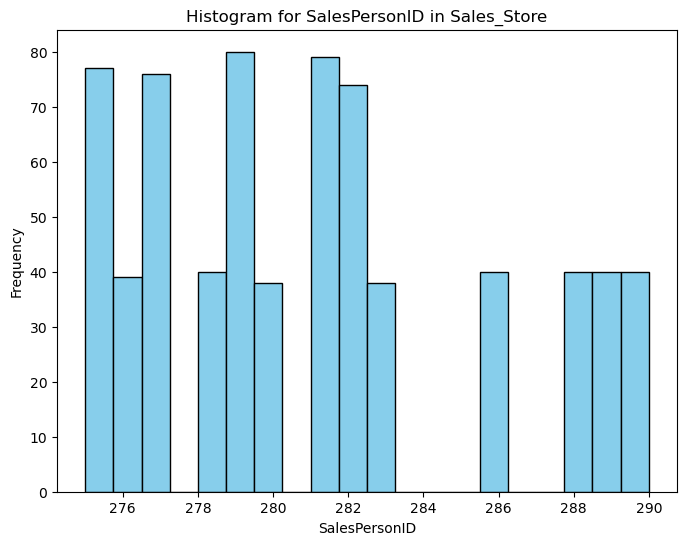

In [266]:
import pandas as pd

# Find the name of all the tables in the database within each schema
# Create a dictionary to store queries, results, and statistics
all_queries_dict = {}
for sch in schemas:
    for table in inspector.get_table_names(schema=sch):
        if sch == 'Person' or sch == 'Sales':
            col_names = ', '.join(col['name'] for col in inspector.get_columns(table_name=table, schema=sch))
            full_table_name = f"{sch}_{table}"
            query = f"SELECT {col_names} FROM {sch}.{table}"
            all_queries_dict[full_table_name] = {'query': query, 'result': None, 'stats': None}

# Put the queries in action and print the results
for full_table_name, data in all_queries_dict.items():
    query = data['query']
    print("QUERY\n------\n", query, "\n", "----------------------------------------------")
    try:
        df_table = pd.read_sql(sql=query, con=connection)
        # Store the DataFrame in the dictionary
        all_queries_dict[full_table_name]['result'] = df_table
        # Calculate basic statistical information using describe
        stats = df_table.describe()
        all_queries_dict[full_table_name]['stats'] = stats
        (schema_name, table_name) = full_table_name.split('_')
        print(f"Schema: {schema_name}\nTable: {table_name}\n")
        print(df_table.head(5))
        print("\nStatistical Information:")
        print(stats)

        # Plot histograms for numeric columns
        numeric_columns = df_table.select_dtypes(include=['number']).columns
        for col in numeric_columns:
            plt.figure(figsize=(8, 6))
            plt.hist(df_table[col], bins=20, color='skyblue', edgecolor='black')
            plt.title(f'Histogram for {col} in {full_table_name}')
            plt.xlabel(col)
            plt.ylabel('Frequency')
            plt.show()

    except Exception as e:
        print(f"Error executing query: {e}")
    print("\n" * 3)

<p>Vi ser att det finns många egenskaper hos kunderna som skulle kunna undersökas närmare för att se ett mönster.</p>

<p>Vi tittar också på <em>views</em> som redan finns presenterade i den originala databasen.</p>

In [270]:
# Do the same for the views
# Make a list of SQL codes for returning the content of all views
all_queries = []
for sch in schemas:
    for view in inspector.get_view_names(schema=sch):
        if sch == 'Person' or sch == 'Sales':
            col_names = ', '.join(col['name'] for col in inspector.get_columns(table_name=view, schema=sch))
            all_queries.append(f"SELECT {col_names} FROM {sch}.{view}")

# Put the queries in action and print the result
qindex = 1
for query in all_queries:
    print("QUERY", qindex, "\n------\n", query, "\n", "----------------------------------------------", "\n")
    try:
        df_view = pd.read_sql(sql=query, con=connection)
        print(df_view.head(15))
    except Exception as e:
        print(f"Error executing query number {qindex}: {e}")
    print("\n"*4)
    qindex = qindex + 1

QUERY 1 
------
 SELECT BusinessEntityID, FirstName, MiddleName, LastName, TelephoneNumber, TelephoneSpecialInstructions, Street, City, StateProvince, PostalCode, CountryRegion, HomeAddressSpecialInstructions, EMailAddress, EMailSpecialInstructions, EMailTelephoneNumber, rowguid, ModifiedDate FROM Person.vAdditionalContactInfo 
 ---------------------------------------------- 

   BusinessEntityID  FirstName MiddleName     LastName TelephoneNumber  \
0               291    Gustavo       None       Achong    425-555-1112   
1               293  Catherine         R.         Abel    206-555-2222   
2               295        Kim       None  Abercrombie    605-555-9877   
3               297   Humberto       None      Acevedo            None   
4               299      Pilar       None     Ackerman            None   
5               301    Frances         B.        Adams            None   
6               303   Margaret         J.        Smith    206-555-2222   
7               305      Car

    BusinessEntityID  TotalPurchaseYTD DateFirstPurchase BirthDate  \
0                  1               0.0               NaT       NaT   
1                  2               0.0               NaT       NaT   
2                  3               0.0               NaT       NaT   
3                  4               0.0               NaT       NaT   
4                  5               0.0               NaT       NaT   
5                  6               0.0               NaT       NaT   
6                  7               0.0               NaT       NaT   
7                  8               0.0               NaT       NaT   
8                  9               0.0               NaT       NaT   
9                 10               0.0               NaT       NaT   
10                11               0.0               NaT       NaT   
11                12               0.0               NaT       NaT   
12                13               0.0               NaT       NaT   
13                14

    BusinessEntityID                                Name  AddressType  \
0                956             Finer Sales and Service  Main Office   
1                780               Finer Riding Supplies  Main Office   
2               1012           Stylish Department Stores  Main Office   
3                482            Favorite Toy Distributor  Main Office   
4               1338             Sports Sales and Rental  Main Office   
5               1424                   Closeout Boutique  Main Office   
6               1274  Self-Contained Cycle Parts Company  Main Office   
7               1958            Ultimate Bicycle Company  Main Office   
8               1110              Local Sales and Rental  Main Office   
9               1262              Roadway Bicycle Supply  Main Office   
10              1490             Engineered Bike Systems  Main Office   
11               704          Only Bikes and Accessories  Main Office   
12              1480              Orange Bicycle Co

In [271]:
# Choose schemas
schemas_of_interest = ['Person', 'Sales']

table_sizes = {}

# Iterate over schemas and tables
for sch in schemas_of_interest:
    table_sizes[sch] = {}
    for view in inspector.get_view_names(schema=sch):
        tables = f'''
            SELECT COUNT(*) FROM {sch}.{view}
        '''
        # Retrieve table sizes and save results in a DataFrame
        df1 = pd.read_sql(sql=tables, con=connection)
        
        # Convert DataFrame to dictionary and store in the main dictionary
        nbr_rows = df1.iloc[0, 0]
        table_sizes[sch][view] = {'rows': nbr_rows}

        columns = f'''
            SELECT COLUMN_NAME
            FROM INFORMATION_SCHEMA.COLUMNS
            WHERE TABLE_SCHEMA = '{sch}' AND TABLE_NAME = '{view}';
        '''

        # Retrieve columns and save results in a DataFrame
        df2 = pd.read_sql(sql=columns, con=connection)
        nbr_cols = df2.shape[0]
        column_list = [df2.iloc[index, 0] for index in range(nbr_cols)]
        
        # Save the sizes of each view and retrieve the names of the columns
        table_sizes[sch][view]['columns'] = column_list
        
# Print the dictionary
print("Table Sizes:", table_sizes)

Table Sizes: {'Person': {'vAdditionalContactInfo': {'rows': 10, 'columns': ['BusinessEntityID', 'FirstName', 'MiddleName', 'LastName', 'TelephoneNumber', 'TelephoneSpecialInstructions', 'Street', 'City', 'StateProvince', 'PostalCode', 'CountryRegion', 'HomeAddressSpecialInstructions', 'EMailAddress', 'EMailSpecialInstructions', 'EMailTelephoneNumber', 'rowguid', 'ModifiedDate']}, 'vStateProvinceCountryRegion': {'rows': 181, 'columns': ['StateProvinceID', 'StateProvinceCode', 'IsOnlyStateProvinceFlag', 'StateProvinceName', 'TerritoryID', 'CountryRegionCode', 'CountryRegionName']}}, 'Sales': {'vIndividualCustomer': {'rows': 18508, 'columns': ['BusinessEntityID', 'Title', 'FirstName', 'MiddleName', 'LastName', 'Suffix', 'PhoneNumber', 'PhoneNumberType', 'EmailAddress', 'EmailPromotion', 'AddressType', 'AddressLine1', 'AddressLine2', 'City', 'StateProvinceName', 'PostalCode', 'CountryRegionName', 'Demographics']}, 'vPersonDemographics': {'rows': 19972, 'columns': ['BusinessEntityID', 'Tota

In [272]:
# Just a clean up of the mess above
for schema, views in table_sizes.items():
    print(f"Schema: {schema}")
    for view, properties in views.items():
        print(f"\n       View: {view}")
        print(f"            Rows: {properties['rows']}")
        print(f"Columns: \n{', '.join(properties['columns'])}")

Schema: Person

       View: vAdditionalContactInfo
            Rows: 10
Columns: 
BusinessEntityID, FirstName, MiddleName, LastName, TelephoneNumber, TelephoneSpecialInstructions, Street, City, StateProvince, PostalCode, CountryRegion, HomeAddressSpecialInstructions, EMailAddress, EMailSpecialInstructions, EMailTelephoneNumber, rowguid, ModifiedDate

       View: vStateProvinceCountryRegion
            Rows: 181
Columns: 
StateProvinceID, StateProvinceCode, IsOnlyStateProvinceFlag, StateProvinceName, TerritoryID, CountryRegionCode, CountryRegionName
Schema: Sales

       View: vIndividualCustomer
            Rows: 18508
Columns: 
BusinessEntityID, Title, FirstName, MiddleName, LastName, Suffix, PhoneNumber, PhoneNumberType, EmailAddress, EmailPromotion, AddressType, AddressLine1, AddressLine2, City, StateProvinceName, PostalCode, CountryRegionName, Demographics

       View: vPersonDemographics
            Rows: 19972
Columns: 
BusinessEntityID, TotalPurchaseYTD, DateFirstPurchase, Bi

Från de senaste utskrifterna kan vi notera att för en rättvis nogrann jämförelse mellan könen behöver vi tabeller med många kunder i. Därför väljer vi <em>vIndividualCustomer</em> och <em>vPersonDemographics</em> från schema <em>Person</em>. Vi gör en Join mellan de två tabllerna och får:

In [273]:
# SQL query for joining the two tables
joint_table = f'''
                SELECT *
                FROM Sales.vPersonDemographics AS VPD
                JOIN Sales.vIndividualCustomer AS VIC
                ON VIC.BusinessEntityID = VPD.BusinessEntityID;
            '''
# Save the result in a dataframe for further investigation
joint_df = pd.read_sql(sql=joint_table, con=connection)
print(joint_df.head(5))

   BusinessEntityID  TotalPurchaseYTD DateFirstPurchase  BirthDate  \
0              9196           -13.500        2003-02-06 1963-06-14   
1             17400           -25.000        2004-01-15 1941-01-05   
2              5124          1130.990        2003-12-20 1979-04-28   
3             17691          1354.545        2002-12-11 1943-02-26   
4              4073           -61.000        2003-12-10 1958-07-01   

  MaritalStatus         YearlyIncome Gender  TotalChildren  \
0             M          50001-75000      M              4   
1             S          25001-50000      F              4   
2             S          25001-50000      M              0   
3             S  greater than 100000      M              2   
4             M         75001-100000      M              5   

   NumberChildrenAtHome        Education  ...                    EmailAddress  \
0                     2       Bachelors   ...    calvin20@adventure-works.com   
1                     0       Bachelors   ..

Vi gör en klassificering av data i kolumnen för årsinkomst och får att:

In [274]:
# Count the number of incomes on each income level
income_counts = joint_df['YearlyIncome'].value_counts()
print(income_counts)

YearlyIncome
25001-50000            5713
50001-75000            5483
0-25000                2922
75001-100000           2762
greater than 100000    1628
Name: count, dtype: int64


För att kunna använda denna kolumn i våra statistiska beräkningar ersätter vi varje intervall med dess max-gräns, dvs:
<ul>
  <li>0-25000 with <b>25,000</b></li>
  <li>25001-50000 with <b>50,000</b></li>
  <li>50001-75000 with <b>75,000</b></li>
  <li>75001-100000 with <b>100,000</b></li>
  <li>greater than 100000 with <b>500,000</b></li>
</ul>
för att göra talen i kolumnerna konverterbara till heltal, inför nästa steg som är att skapa en korrelationsmatris. Vi kommer inte använda själva talen i våra beräkningar så det finns ingen risk att våra beräkningar genererar felaktiga resultat. Med andra ord använder vi årsinkomsten endast som en ordinal, kategorisk variabel.

In [275]:
# Make a regex to differentiate between the 'nnnnn-nnnnn' and 'greater then 100000'
pattern = r'-(\d+)| (\d+)'

# Apply the regex pattern on all the cells, remove NaN and convert the result to int
matches = joint_df['YearlyIncome'].str.extract(pattern).fillna(0).astype(int)

# Use the apply function to find the maximum value for each row and save it in a new column
joint_df['YearlyIncomex'] = matches.apply(lambda row: max(row[0], row[1]*5), axis=1)

print(joint_df)

       BusinessEntityID  TotalPurchaseYTD DateFirstPurchase  BirthDate  \
0                  9196           -13.500        2003-02-06 1963-06-14   
1                 17400           -25.000        2004-01-15 1941-01-05   
2                  5124          1130.990        2003-12-20 1979-04-28   
3                 17691          1354.545        2002-12-11 1943-02-26   
4                  4073           -61.000        2003-12-10 1958-07-01   
...                 ...               ...               ...        ...   
18503             20773            54.480        2004-04-19 1974-11-23   
18504             20774           -13.010        2003-08-30 1961-06-12   
18505             20775           112.580        2004-04-12 1940-04-05   
18506             20776            -9.510        2004-02-15 1975-07-25   
18507             20777           -19.500        2003-11-17 1971-05-05   

      MaritalStatus         YearlyIncome Gender  TotalChildren  \
0                 M          50001-75000     

<h2>Övergång från kategorisk data till ordinal data</h2>

In [276]:
# Marital Status
income_counts = joint_df['MaritalStatus'].value_counts()
print(income_counts)

MaritalStatus
M    10025
S     8483
Name: count, dtype: int64


In [277]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

In [278]:
from datetime import datetime

encoded_dates = label_encoder.fit_transform(joint_df['DateFirstPurchase'])

# Convert the encoded dates to strings
date_strings = joint_df['DateFirstPurchase'].astype(str)

# Extract the first four characters (digits) from each date
year = date_strings.str[:4]
year_from_date = pd.to_numeric(year)

# Calculate the interval between the year from date and the current year
current_year = datetime.now().year
joint_df['Lengthx'] = current_year - year_from_date

joint_df['Lengthx']

0        21
1        20
2        21
3        22
4        21
         ..
18503    20
18504    21
18505    20
18506    20
18507    21
Name: Lengthx, Length: 18508, dtype: int64

In [279]:
encoded_dates = label_encoder.fit_transform(joint_df['BirthDate'])

# Convert the encoded dates to strings
date_strings = joint_df['BirthDate'].astype(str)

# Extract the first four characters (digits) from each date
year = date_strings.str[:4]
year_from_date = pd.to_numeric(year)

# Calculate the interval between the year from date and the current year
# Choosing 1998 as the current year gives a time span of 18 through 88,
# which sounds more reasonable than any other end date
current_year = 1998
joint_df['Agex'] = current_year - year_from_date

print(f"Minimum age of the customers: {min(joint_df['Agex'])}")
print(f"Maximum age of the customers: {max(joint_df['Agex'])}")
joint_df['Agex']

Minimum age of the customers: 18
Maximum age of the customers: 88


0        35
1        57
2        19
3        55
4        40
         ..
18503    24
18504    37
18505    58
18506    23
18507    27
Name: Agex, Length: 18508, dtype: int64

In [280]:
# We choose the length of each customer's membership divided by
# his/her age, as an indicator of that customer's loyalty
joint_df['Loyaltyx'] = joint_df['Lengthx'] / joint_df['Agex']

joint_df['Loyaltyx']

0        0.600000
1        0.350877
2        1.105263
3        0.400000
4        0.525000
           ...   
18503    0.833333
18504    0.567568
18505    0.344828
18506    0.869565
18507    0.777778
Name: Loyaltyx, Length: 18508, dtype: float64

På de följande raderna försöker vi skapa nya kolumner med tal istället för stränar, för att undvika problemet med att omvandla tabellceller till <em>float</em>.

In [281]:
joint_df['MaritalStatusx'] = label_encoder.fit_transform(joint_df['MaritalStatus'])

# Display the mapping of original labels to encoded integers
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'M': 0, 'S': 1}


In [282]:
joint_df['Genderx'] = label_encoder.fit_transform(joint_df['Gender'])

# Display the mapping of original labels to encoded integers
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'F': 0, 'M': 1}


In [283]:
joint_df['Educationx'] = label_encoder.fit_transform(joint_df['Education'])

# Display the mapping of original labels to encoded integers
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'Bachelors ': 0, 'Graduate Degree': 1, 'High School': 2, 'Partial College': 3, 'Partial High School': 4}


In [284]:
joint_df['Occupationx'] = label_encoder.fit_transform(joint_df['Occupation'])

# Display the mapping of original labels to encoded integers
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'Clerical': 0, 'Management': 1, 'Manual': 2, 'Professional': 3, 'Skilled Manual': 4}


In [285]:
joint_df['HomeOwnerFlagx'] = label_encoder.fit_transform(joint_df['HomeOwnerFlag'])

# Display the mapping of original labels to encoded integers
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {False: 0, True: 1}


In [286]:
joint_df['CountryRegionNamex'] = label_encoder.fit_transform(joint_df['CountryRegionName'])

# Display the mapping of original labels to encoded integers
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'Australia': 0, 'Canada': 1, 'France': 2, 'Germany': 3, 'United Kingdom': 4, 'United States': 5}


<h2>Försök 1: hitta samband mellan Total Purchase YTD och andra faktorer</h2>

Nu kan vi använda de nya kolumnerna till att beräkna korrelationen mellan alla dessa variabler, med hopp om att hitta variabler som är mer korrelerade med andra, speciellt de som är kopplade till kundernas kön.

In [287]:
joint_df['StateProvinceNamex'] = label_encoder.fit_transform(joint_df['StateProvinceName'])

# Display the mapping of original labels to encoded integers
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'Alabama': 0, 'Alberta': 1, 'Arizona': 2, 'Bayern': 3, 'Brandenburg': 4, 'British Columbia': 5, 'California': 6, 'Charente-Maritime': 7, 'England': 8, 'Essonne': 9, 'Florida': 10, 'Garonne (Haute)': 11, 'Georgia': 12, 'Hamburg': 13, 'Hauts de Seine': 14, 'Hessen': 15, 'Illinois': 16, 'Kentucky': 17, 'Loir et Cher': 18, 'Loiret': 19, 'Maryland': 20, 'Massachusetts': 21, 'Minnesota': 22, 'Mississippi': 23, 'Missouri': 24, 'Montana': 25, 'Moselle': 26, 'New South Wales': 27, 'New York': 28, 'Nord': 29, 'Nordrhein-Westfalen': 30, 'North Carolina': 31, 'Ohio': 32, 'Ontario': 33, 'Oregon': 34, 'Pas de Calais': 35, 'Queensland': 36, 'Saarland': 37, 'Seine (Paris)': 38, 'Seine Saint Denis': 39, 'Seine et Marne': 40, 'Somme': 41, 'South Australia': 42, 'South Carolina': 43, 'Tasmania': 44, 'Texas': 45, 'Utah': 46, "Val d'Oise": 47, 'Val de Marne': 48, 'Victoria': 49, 'Virginia': 50, 'Washington': 51, 'Wyoming': 52, 'Yveline': 53}


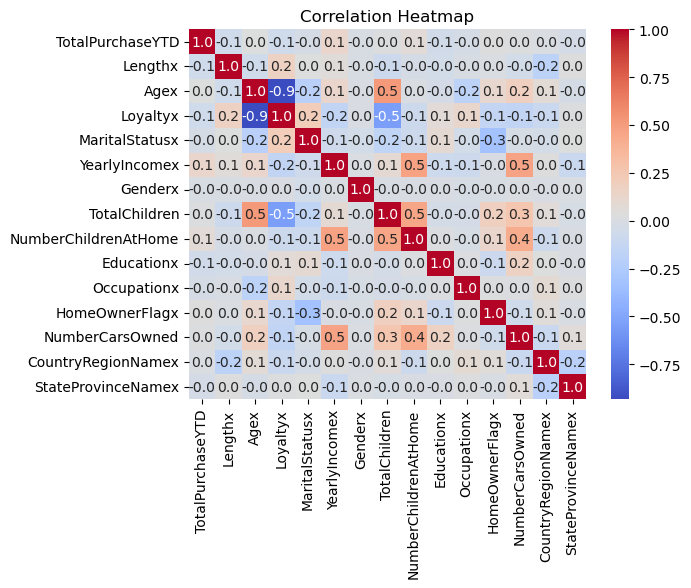

In [290]:
import seaborn as sns

# Create a correlation matrix to present the relation between all 
correlation_matrix = joint_df[['TotalPurchaseYTD', 'Lengthx', 'Agex', 'Loyaltyx', 'MaritalStatusx', 'YearlyIncomex', 'Genderx', 'TotalChildren',
                               'NumberChildrenAtHome', 'Educationx', 'Occupationx', 'HomeOwnerFlagx', 
                               'NumberCarsOwned', 'CountryRegionNamex', 'StateProvinceNamex']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Correlation Heatmap')
plt.show()

Från tabellen kan vi endast utläsa vilka par av variabler som är mer korrelerade än andra, nämligen:
Agex-Loyaltyx (0.9; detta är framför allt pga vår egen definition of Loyalty),
Agex-TotalChildren (0.5),
NumberChildren-TotalChildren (0.5),
YearlyIncome-NumberCarsOwned (0.5),
TotalChildren-Loyaltyx (-0.5),
Inga av dessa är relevanta för vår studie och därför överger vi den undersökningen och söker lycka någon annanstans.

Den enda finansiellt relevanta slutsats vi kan dra är att lojalitet är "mot-korrelerad" mot antal barn som i sin tur är korrelerad med ålder. Detta betyder att de äldre tenderar att visa mindre lojalitet, vilket kan förstås i och med att de äldre har fler barn och både har mindre tid att handla och mindre pengar att spendera på egna intressen.

I nästa steg tittar vi på inkomster och försöker hitta ett samband mellan könerna och hur mycket de tjänar och spenderar.

<h2>Försök 2: hitta skillnad i inkomst och köpvana hos de mest entusiastiska män och kvinnor</h2>

In [291]:
# Count the number of incomde levels
expenditure_counts = joint_df['TotalPurchaseYTD'].value_counts()
print(expenditure_counts)

TotalPurchaseYTD
-4.9900       501
-30.0000      481
-3578.2700    310
 2.7000       296
-69.9900      245
             ... 
 2322.9618      1
 546.3950       1
 259.5800       1
 19.4700        1
 3513.8100      1
Name: count, Length: 3994, dtype: int64


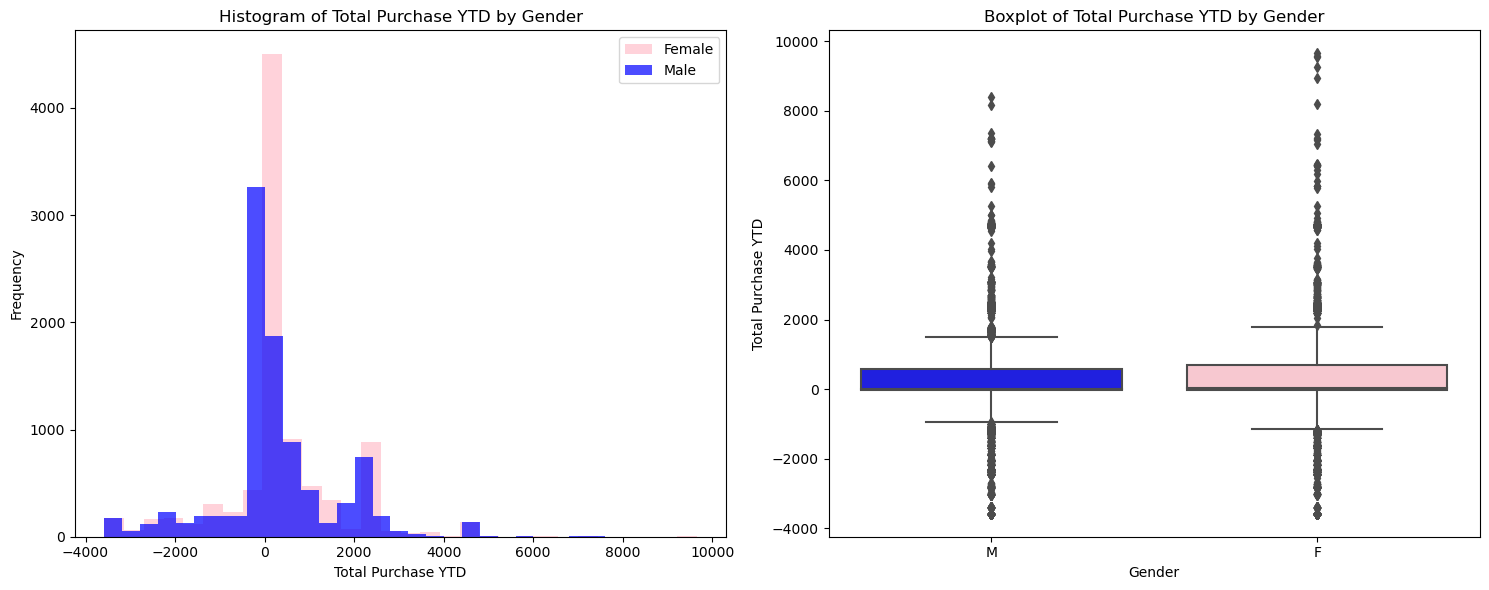

In [292]:
YIx_female = joint_df.loc[joint_df['Gender'] == 'F', 'TotalPurchaseYTD']
YIx_male = joint_df.loc[joint_df['Gender'] == 'M', 'TotalPurchaseYTD']

# Plot histograms
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.hist(YIx_female, bins=30, alpha=0.7, label='Female', color='pink')
plt.hist(YIx_male, bins=30, alpha=0.7, label='Male', color='blue')
plt.xlabel('Total Purchase YTD')
plt.ylabel('Frequency')
plt.title('Histogram of Total Purchase YTD by Gender')
plt.legend()

# Plot boxplots
plt.subplot(1, 2, 2)
sns.boxplot(x='Gender', y='TotalPurchaseYTD', data=joint_df, palette={'F': 'pink', 'M': 'blue'})
plt.xlabel('Gender')
plt.ylabel('Total Purchase YTD')
plt.title('Boxplot of Total Purchase YTD by Gender')

plt.tight_layout()
plt.show()

In [293]:
import numpy as np
import scipy.stats as stats

# Separate the table based on M/F for 'Gender'
YTD_female = joint_df.loc[joint_df['Gender'] == 'F', 'TotalPurchaseYTD']
YTD_male = joint_df.loc[joint_df['Gender'] == 'M', 'TotalPurchaseYTD']

# Check for zero variance
if np.var(YTD_female, ddof=1) == 0 or np.var(YTD_male, ddof=1) == 0:
    print("Error: One or both groups have zero variance.")
else:
    # Calculate t-statistic and p-value
    t_stat, p_value = stats.ttest_ind(YTD_female, YTD_male, equal_var=False)

    # Degrees of freedom
    df = len(YTD_female) + len(YTD_male) - 2

    # Significance level (e.g., 95% confidence interval)
    alpha = 0.05

    # Calculate standard error of the difference
    std_err_diff = np.sqrt((np.var(YTD_female, ddof=1) / len(YTD_female)) + (np.var(YTD_male, ddof=1) / len(YTD_male)))

    # Calculate margin of error
    margin_of_error = stats.t.ppf(1 - alpha / 2, df) * std_err_diff

    # Calculate confidence interval
    mean_diff = np.mean(YTD_female) - np.mean(YTD_male)
    confidence_interval = (mean_diff - margin_of_error, mean_diff + margin_of_error)

    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")
    print(f"Confidence Interval: {confidence_interval}")

T-statistic: 0.7885667920652966
P-value: 0.43037536312561386
Confidence Interval: (-23.324626429997387, 54.72475825253415)


Detta betyder att det inte finns någon signifikant skillnad i generella drag mellan hur mycket män och kvinnor spenderar på köp av cykel och tillbehöver.

Om vi tittar på spridningsdiagrammet för hela populationen, märker vi att de högsta beloppen spenderas av de som är mellan 40 och 55 år gamla.

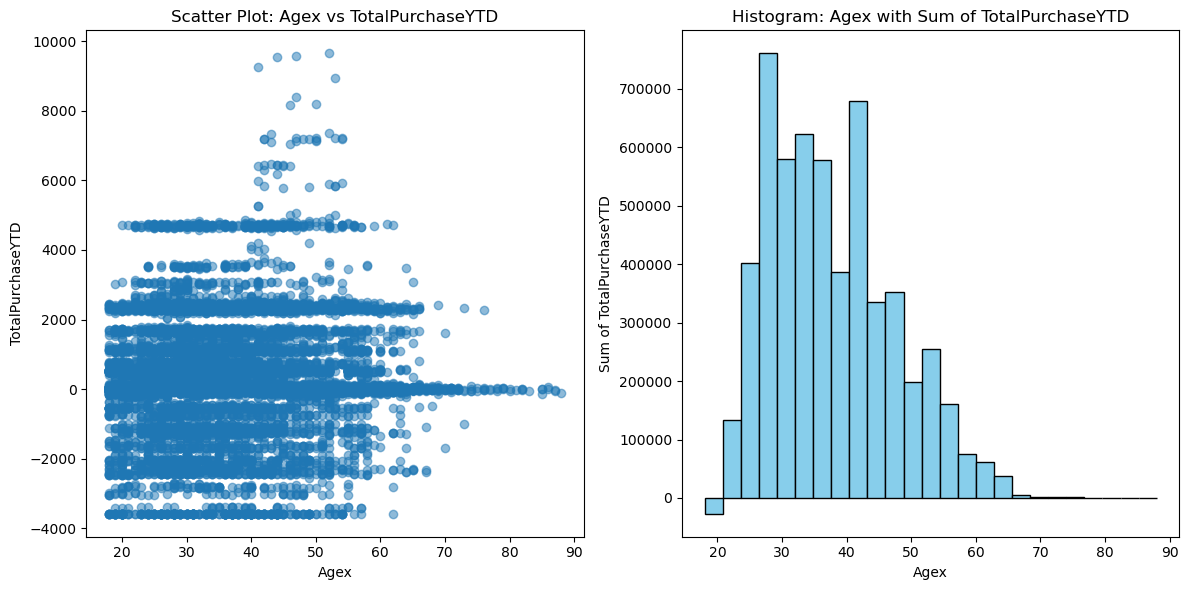

In [296]:
# Assuming joint_df is your DataFrame
plt.figure(figsize=(12, 6))

# Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(joint_df['Agex'], joint_df['TotalPurchaseYTD'], alpha=0.5)
plt.title('Scatter Plot: Agex vs TotalPurchaseYTD')
plt.xlabel('Agex')
plt.ylabel('TotalPurchaseYTD')

# Histogram with sum of TotalPurchaseYTD
plt.subplot(1, 2, 2)
plt.hist(joint_df['Agex'], bins=25, weights=joint_df['TotalPurchaseYTD'], color='skyblue', edgecolor='black')
plt.title('Histogram: Agex with Sum of TotalPurchaseYTD')
plt.xlabel('Agex')
plt.ylabel('Sum of TotalPurchaseYTD')

plt.tight_layout()
plt.show()

Så vi separerar den gruppen som spenderar mer än 5000 dollar per år och tittar på skillnaden mellan män och kvinnor inom den gruppen av kunder.

In [299]:
# Create a boolean mask for individuals who have spent more than $5000 YTD
mask_high_spenders = joint_df['TotalPurchaseYTD'] >= 5000

# Use the mask to filter rows and extract information about gender
high_spenders_data = joint_df.loc[mask_high_spenders, ['Genderx', 'TotalPurchaseYTD', 'Agex']]

# Sort the data based on both 'Genderx' and 'Agex'
sorted_data = high_spenders_data.sort_values(by=['Genderx', 'Agex'])

# Print or further analyze the sorted data
print(sorted_data)

       Genderx  TotalPurchaseYTD  Agex
80           0         9263.6618    41
15683        0         5263.5004    41
16199        0         5982.1800    41
16396        0         6414.0304    41
2286         0         7186.8700    42
2671         0         5839.5304    42
11624        0         6432.0304    42
12020        0         6303.0318    42
4950         0         6459.0200    43
18340        0         7341.0500    43
547          0         6443.0100    44
5926         0         6189.9736    44
15441        0         9547.5500    44
17516        0         6429.0300    44
7447         0         6435.0100    45
11555        0         6408.0400    45
12808        0         5786.5404    45
14037        0         7045.3800    46
2646         0         9566.4300    47
5149         0         5052.4108    47
3897         0         8201.3808    50
10039        0         7151.3875    50
14325        0         9650.7600    52
28           0         5840.5304    53
10089        0         89

In [300]:
# Filter the data based on the specified conditions
filtered_data = joint_df[(joint_df['TotalPurchaseYTD'] >= 5000) & 
                          (joint_df['Agex'] >= 41) & (joint_df['Agex'] <= 54)]

# Split the data into two groups based on Genderx
group_0 = filtered_data[filtered_data['Genderx'] == 0]['TotalPurchaseYTD']
group_1 = filtered_data[filtered_data['Genderx'] == 1]['TotalPurchaseYTD']

# Perform an independent t-test
t_stat, p_value = stats.ttest_ind(group_0, group_1, equal_var=False)

# Print the results
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

# Check if the p-value is less than the significance level 0.05
if p_value < 0.05:
    print('Reject the null hypothesis: There is a significant difference between the groups.')
else:
    print('Fail to reject the null hypothesis: There is no significant difference between the groups.')

T-statistic: 0.6506527831141421
P-value: 0.5185818626557512
Fail to reject the null hypothesis: There is no significant difference between the groups.


Vi finner återigen ingen signifikant skillnad mellan dessa värden:

In [301]:
# Set the desired significance level
alpha = 0.12

# Check if the p-value is less than the significance level
if p_value < alpha:
    print(f'Reject the null hypothesis at {alpha} significance level: There is a significant difference between the groups.')
else:
    print(f'Fail to reject the null hypothesis at {alpha} significance level: There is no significant difference between the groups.')

Fail to reject the null hypothesis at 0.12 significance level: There is no significant difference between the groups.


<h2>Försök 3: hitta skillnad i köpvana mellan kvinnor och män i de olika spenderarklasserna</h2>

Efter att inte ha lyckats med att hitta någon skillnad mellan de från båda könen som spenderar mest på köp av cyklar och tillbehör, gör vi ett försök med att se om det förekommer någon signifikant skillnad i hur mycket män och kvinnor i varje inkomstklass spenderar på sin hobby.

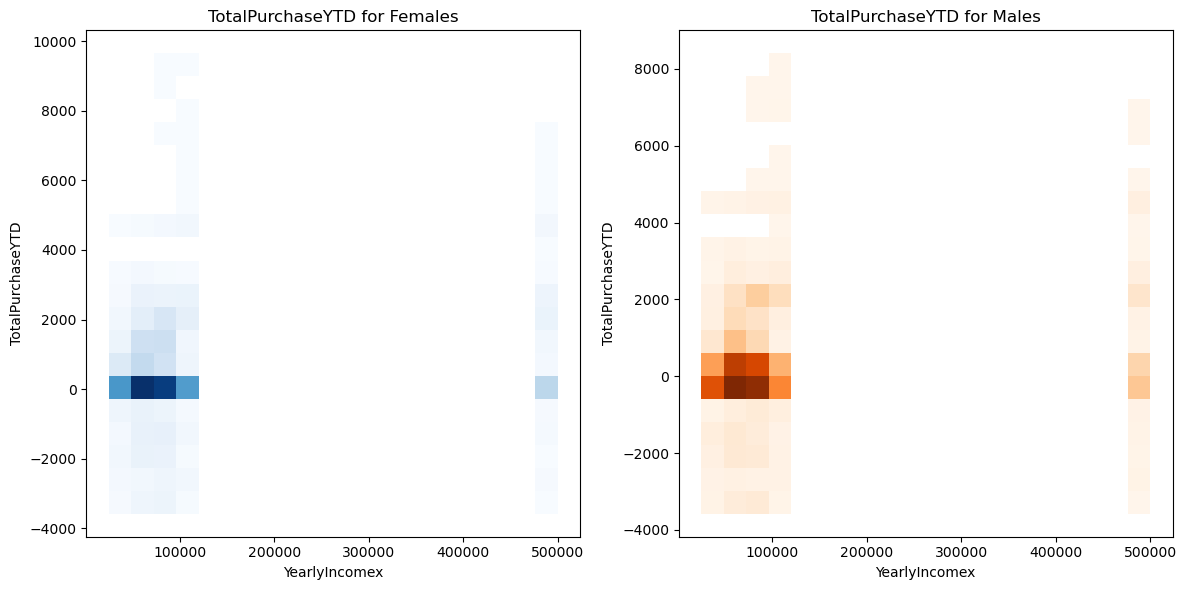

In [223]:
# Filter data for females and males
female_data = joint_df[joint_df['Genderx'] == 0]
male_data = joint_df[joint_df['Genderx'] == 1]

# Plot histograms
plt.figure(figsize=(12, 6))

# Histogram for females
plt.subplot(1, 2, 1)
sns.histplot(data=female_data, x='YearlyIncomex', y='TotalPurchaseYTD', bins=20, cmap='Blues')
plt.title('TotalPurchaseYTD for Females')

# Histogram for males
plt.subplot(1, 2, 2)
sns.histplot(data=male_data, x='YearlyIncomex', y='TotalPurchaseYTD', bins=20, cmap='Oranges')
plt.title('TotalPurchaseYTD for Males')

plt.tight_layout()
plt.show()

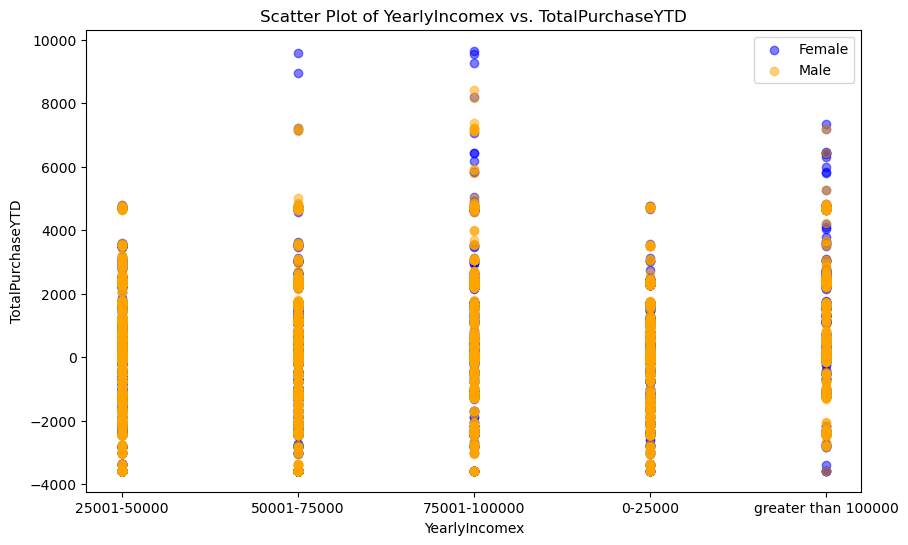

In [225]:
# Separate data for females and males
female_data = joint_df[joint_df['Genderx'] == 0]
male_data = joint_df[joint_df['Genderx'] == 1]

# Scatter plot
plt.figure(figsize=(10, 6))

# Plot females in blue
plt.scatter(female_data['YearlyIncome'], female_data['TotalPurchaseYTD'], color='blue', label='Female', alpha=0.5)

# Plot males in orange
plt.scatter(male_data['YearlyIncome'], male_data['TotalPurchaseYTD'], color='orange', label='Male', alpha=0.5)

plt.title('Scatter Plot of YearlyIncomex vs. TotalPurchaseYTD')
plt.xlabel('YearlyIncomex')
plt.ylabel('TotalPurchaseYTD')
plt.legend()
plt.show()

In [304]:
import statsmodels.api as sm

# Separate data for females and males
female_data = joint_df[joint_df['Genderx'] == 0]
male_data = joint_df[joint_df['Genderx'] == 1]

# Define the confidence level
confidence_level = 0.95

# Group data by 'YearlyIncome'
grouped_female = female_data.groupby('YearlyIncome')['TotalPurchaseYTD']
grouped_male = male_data.groupby('YearlyIncome')['TotalPurchaseYTD']

# Collect confidence intervals
confidence_intervals = []

for income_interval, female_values in grouped_female:
    male_values = grouped_male.get_group(income_interval)
    
    # Calculate confidence interval for the difference between means
    diff_means = np.mean(female_values) - np.mean(male_values)
    std_err = sm.stats.CompareMeans.from_data(female_values, male_values).zconfint_diff(alpha=1 - confidence_level)
    
    # Collect results
    interval_data = {
        'YearlyIncome': income_interval,
        'DiffMeans': diff_means,
        'ConfidenceInterval': std_err
    }
    confidence_intervals.append(interval_data)

# Display confidence intervals
df_intervals = pd.DataFrame(confidence_intervals)
print(df_intervals)

          YearlyIncome   DiffMeans                        ConfidenceInterval
0              0-25000   36.945527   (-35.62309491373986, 109.5141486056196)
1          25001-50000   -3.755627   (-68.14993872067124, 60.63868448816346)
2          50001-75000   -1.190903   (-74.36801905155842, 71.98621260098254)
3         75001-100000   -0.272717  (-115.50074949730732, 114.9553150625617)
4  greater than 100000  138.540454  (-20.90936173573448, 297.99027048409255)


Även här hittar vi alltså ingen signifikant skillnad mellan hur män och kvinnors köpvana, när det kommer till cykel och tillbehör.

In [303]:
# Separate data for females and males
female_data = joint_df[joint_df['Genderx'] == 0]
male_data = joint_df[joint_df['Genderx'] == 1]

# Define the confidence level
confidence_level = 0.95

# Group data by 'YearlyIncome'
grouped_female = female_data.groupby('YearlyIncome')['TotalPurchaseYTD']
grouped_male = male_data.groupby('YearlyIncome')['TotalPurchaseYTD']

# Collect p-values
p_values = []

for income_interval, female_values in grouped_female:
    male_values = grouped_male.get_group(income_interval)
    
    # Calculate p-value for the two-sample t-test
    _, p_value = stats.ttest_ind(female_values, male_values)
    
    # Collect results
    result_data = {
        'YearlyIncome': income_interval,
        'p_value': p_value
    }
    p_values.append(result_data)

# Display p-values
df_p_values = pd.DataFrame(p_values)
print(df_p_values)

          YearlyIncome   p_value
0              0-25000  0.318439
1          25001-50000  0.908996
2          50001-75000  0.974555
3         75001-100000  0.996299
4  greater than 100000  0.088769


In [ ]:
Vi hittar därmed ingen skillnad mellan kvinnor och män i hur de spenderar sin inkomst på sin hobby.